In [158]:
"""
This example is from doi:10.1016/j.jcat.2007.05.011, Horn 2007
Ref 17 is doi:10.1016/j.cat.2006.05.008
Ref 18 is doi:10.1007/s10562-006-0117-8

surface to reactor volume ratio (assuming same active catalytic area) A/V, at 1600.0 m-1, from Ref 17
assume catalyst is a monolith, at 16.5 mm in diam, from Ref 17 & Ref 18
porosity is 0.81, from Ref 17
front heat sheild, cataylst, and back heat sheild is 10 mm long, from Ref 17
inlet mol flow at 0.208 mol/min

graphs are in:
exit conversion % v c/0 ratio
flow/mol/min v position(mm)
S at end oxidation zone/ % v C/O ratio
selectivity S, yield(Y)/% v C/O ratio
flow/ mol/min v position (z)/ mm

also had plots with flow/ mol/ min v C/O ratio w lines of thermodynamic equilibrium )ph = const)
"""

# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
import csv
from pydas.dassl import DASSL
import os
import rmgpy
import rmg
import re
import operator
import pandas as pd
import pylab
from cycler import cycler
import seaborn as sns
import os
%matplotlib inline

# this chemkin file is from the cti generated by rmg
# i only need to import it once
gas = ct.Solution('./chem_annotated.cti','gas')
surf = ct.Interface('./chem_annotated.cti','surface1', [gas])

print "This mechanism contains %d gas reactions and %d surface reactions"%(gas.n_reactions, surf.n_reactions)
i_ar = gas.species_index('Ar')
i_ch4 = gas.species_index('CH4(2)')
i_o2 = gas.species_index('O2(3)')
i_co2 = gas.species_index('CO2(4)')
i_h2o = gas.species_index('H2O(5)')
i_h2 = gas.species_index('H2(6)')
i_co = gas.species_index('CO(7)')

fixed_temp_errors = []

# unit conversion factors to SI
mm = 0.001
cm = 0.01
ms = mm
minute = 60.0

#######################################################################
# Input Parameters
#######################################################################
# t_in = 673.15 #K - in the paper, it was ~400K at the start of the cat surface and ~200 for the gas inlet temp
# t_cat = t_in 
length = 25 * mm  # Reactor length - catalyst length 10mm, but it doesn't say where.  let's guess at 1 cm?
diam = 19.*mm # Reactor diameter 
area = (diam/2.0)**2*np.pi  # Reactor cross section area (area of tube) in m^2
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 1600.  # Catalyst particle surface area per unit volume in m-1
# cat_area_per_vol = 10000.
flow_rate = 4.7 # slpm
flow_rate = flow_rate*.001/60 # m^3/s
velocity = flow_rate/area # m/s
print velocity

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2501

on_catalyst = 1000
off_catalyst = 2000
dt = 1.0

reactor_len = length/(NReactors-1)
rvol = area * reactor_len * porosity

# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol

mass_flow_rate = velocity * gas.density * area # kg/s

This mechanism contains 38 gas reactions and 41 surface reactions
0.27628004895


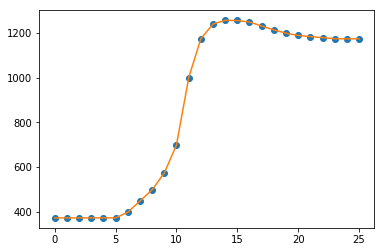

In [38]:
temp_profile = np.array([ # [reactor location (mm), temperature (K)]
        [0.,373.15],
        [1.,373.15],
        [2.,373.15],
        [3.,373.15],
        [4.,373.15],
        [5.,373.15],
        [6.,398.15],
        [7.,448.15],
        [8.,498.15],
        [9.,573.15],
        [10.,698.15],
        [11.,998.15],
        [12.,1173.15],
        [13.,1239.15],
        [14.,1256.15],
        [15.,1255.15],
        [16.,1248.15],
        [17.,1230.15],
        [18.,1213.15],
        [19.,1198.15],
        [20.,1188.15],
        [21.,1183.15],
        [22.,1178.15],
        [23.,1173.15],
        [24.,1173.15],
        [25.,1173.15],])

x = temp_profile[:,0]
y = temp_profile[:,1]

# more refined temp profile
a = np.linspace(0,25,2501)
q = []
for k in range(len(y)-1):
    if k <= len(y)-3:
        p = (np.linspace(y[k],y[k+1],100,endpoint=False))
    else:
        p = (np.linspace(y[k],y[k+1],101))
    q.append(p.tolist())
b = [item for sublist in q for item in sublist]

plt.plot(x,y,'o')
plt.plot(a,b)
temp_array = b
plt.show()

In [210]:
def monolithFull(gas,surf,temp,mol_in,verbose=False,sens=False):
    """
    Verbose prints out values as you go along
    Sens is for sensitivity, in the form [perturbation, reaction #]
    """
    T_prof = temp
    
    ch4,o2,ar = mol_in
    ch4=str(ch4);o2=str(o2);ar=str(ar)
    X = str('CH4(2):'+ch4+', O2(3):'+o2+', Ar:'+ar)
    gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
    # mass_flow_rate = velocity * gas.density_mass * area  # kg/s
    mass_flow_rate = flow_rate * gas.density_mass
    gas.TPX = T_prof[0], ct.one_atm, X
    surf.TP = T_prof[0], ct.one_atm
    surf.coverages = 'X(1):1.0'
    gas.set_multiplier(1.0)
    
    TDY = gas.TDY
    cov = surf.coverages

    if verbose is True:
        print('  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')

    # create a new reactor
    gas.TDY = TDY
    r = ct.IdealGasReactor(gas)
    r.volume = rvol

    # create a reservoir to represent the reactor immediately upstream. Note
    # that the gas object is set already to the state of the upstream reactor
    upstream = ct.Reservoir(gas, name='upstream')

    # create a reservoir for the reactor to exhaust into. The composition of
    # this reservoir is irrelevant.
    downstream = ct.Reservoir(gas, name='downstream')

    # Add the reacting surface to the reactor. The area is set to the desired
    # catalyst area in the reactor.
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)

    # The mass flow rate into the reactor will be fixed by using a
    # MassFlowController object.
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

    # We need an outlet to the downstream reservoir. This will determine the
    # pressure in the reactor. The value of K will only affect the transient
    # pressure difference.
    v = ct.PressureController(r, downstream, master=m, K=1e-5)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12

    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-10
    sim.atol = 1.0e-18

    gas_names = gas.species_names
    surf_names = surf.species_names
    gas_out = [] # in mol fractions
    surf_out = []
    dist_array=[]
    T_array = []


    surf.set_multiplier(0.0) #no surface reactions until the gauze
    for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY =  T_prof[n],r.thermo.TDY[1],r.thermo.TDY[2]
        upstream.syncState()
        if n==on_catalyst:
            surf.set_multiplier(1.0)
            if sens is not False:
                surf.set_multiplier(1.0+sens[0],sens[1])
        if n==off_catalyst:
            surf.set_multiplier(0.0)
        # Integrate the reactor forward in time until steady state has been reached
        sim.reinitialize()
        sim.advance_to_steady_state()
        
        dist = n * reactor_len * 1.0e3   # distance in mm
        dist_array.append(dist)
        T_array.append(surf.T)
        gas_out.append(gas.X.copy())
        surf_out.append(surf.X.copy())
        
        # make reaction diagrams
#         out_dir = 'fixed-temp/rxnpath'
#         os.path.exists(out_dir) or os.makedirs(out_dir)
#         elements = ['H', 'O']
#         locations_of_interest = [1000,1100,1200,1300,1999]
#         for l in locations_of_interest:
#             if n==l:
#                 location = str(int(n/100))

#                 diagram = ct.ReactionPathDiagram(surf,'X')
#                 diagram.title = 'rxn path'
#                 diagram.label_threshold = 1e-9
#                 dot_file = 'rxnpath-ft-x-' + location + 'mm' + '.dot'
#                 img_file = 'rxnpath-ft-x-' + location + 'mm' + '.png'
#                 img_path = os.path.join(os.getcwd(), img_file)
#                 diagram.write_dot(dot_file)
#                 os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
#                   
#                 for element in elements:
#                     diagram = ct.ReactionPathDiagram(gas,element)
#                     diagram.title = element + 'rxn path'
#                     diagram.label_threshold = 1e-9
#                     dot_file = 'rxnpath-ft-gas-' + location + 'mm-' + element + '.dot'
#                     img_file = 'rxnpath-ft-gas-' + location + 'mm-' + element + '.png'
#                     img_path = os.path.join(os.getcwd(), img_file)
#                     diagram.write_dot(dot_file)
#                     os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
#                     
#                     diagram = ct.ReactionPathDiagram(surf,element)
#                     diagram.title = element + 'rxn path'
#                     diagram.label_threshold = 1e-9
#                     dot_file = 'rxnpath-ft-surf-' + location + 'mm-' + element + '.dot'
#                     img_file = 'rxnpath-ft-surf-' + location + 'mm-' + element + '.png'
#                     img_path = os.path.join(os.getcwd(), img_file)
#                     diagram.write_dot(dot_file)
#                     os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))

        if verbose is True:
            if not n % 100:
                print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist, *gas['CH4(2)','O2(3)','H2(6)','CO(7)','H2O(5)','CO2(4)'].X))
                #print(surf.T)
                #print(gas.P)
                #print(surf.coverages)

    gas_out = np.array(gas_out)
    surf_out = np.array(surf_out)
    gas_names = np.array(gas_names)
    surf_names = np.array(surf_names)
    return gas_out, surf_out, gas_names, surf_names, dist_array, T_array

def monolithDeutschmann(gas,surf,temp,mol_in,verbose=False,sens=False):
    """
    Verbose prints out values as you go along
    Sens is for sensitivity, in the form [perturbation, reaction #]
    """
    T_prof = temp
    
    ch4,o2,ar = mol_in
    ch4=str(ch4);o2=str(o2);ar=str(ar)
    X = str('CH4:'+ch4+', O2:'+o2+', Ar:'+ar)
    gas.TPX = T_prof[0], ct.one_atm, X
    surf.TP = T_prof[0], ct.one_atm
    surf.coverages = 'Pt_ads:1.0'
    gas.set_multiplier(1.0)
    
    TDY = gas.TDY
    cov = surf.coverages

    if verbose is True:
        print('  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')

    # create a new reactor
    gas.TDY = TDY
    r = ct.IdealGasReactor(gas)
    r.volume = rvol

    # create a reservoir to represent the reactor immediately upstream. Note
    # that the gas object is set already to the state of the upstream reactor
    upstream = ct.Reservoir(gas, name='upstream')

    # create a reservoir for the reactor to exhaust into. The composition of
    # this reservoir is irrelevant.
    downstream = ct.Reservoir(gas, name='downstream')

    # Add the reacting surface to the reactor. The area is set to the desired
    # catalyst area in the reactor.
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)

    # The mass flow rate into the reactor will be fixed by using a
    # MassFlowController object.
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

    # We need an outlet to the downstream reservoir. This will determine the
    # pressure in the reactor. The value of K will only affect the transient
    # pressure difference.
    v = ct.PressureController(r, downstream, master=m, K=1e-5)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12

    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-10
    sim.atol = 1.0e-20

    gas_names = gas.species_names
    surf_names = surf.species_names
    gas_out = [] # in mol fractions
    surf_out = []
    dist_array=[]
    T_array = []


    surf.set_multiplier(0.0) #no surface reactions until the gauze
    for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY =  T_prof[n],r.thermo.TDY[1],r.thermo.TDY[2]
        upstream.syncState()
        if n==on_catalyst:
            surf.set_multiplier(1.0)
            if sens is not False:
                surf.set_multiplier(1.0+sens[0],sens[1])
        if n==off_catalyst:
            surf.set_multiplier(0.0)
        # Integrate the reactor forward in time until steady state has been reached
        sim.reinitialize()
        sim.advance_to_steady_state()
        
        dist = n * reactor_len * 1.0e3   # distance in mm
        dist_array.append(dist)
        T_array.append(surf.T)
        gas_out.append(gas.X.copy())
        surf_out.append(surf.X.copy())
        
        # make reaction diagrams
#         out_dir = 'fixed-temp/rxnpath'
#         os.path.exists(out_dir) or os.makedirs(out_dir)
#         elements = ['H', 'O']
#         locations_of_interest = [1000,1100,1200,1300,1999]
#         for l in locations_of_interest:
#             if n==l:
#                 location = str(int(n/100))

#                 diagram = ct.ReactionPathDiagram(surf,'X')
#                 diagram.title = 'rxn path'
#                 diagram.label_threshold = 1e-9
#                 dot_file = 'rxnpath-ft-x-' + location + 'mm' + '.dot'
#                 img_file = 'rxnpath-ft-x-' + location + 'mm' + '.png'
#                 img_path = os.path.join(os.getcwd(), img_file)
#                 diagram.write_dot(dot_file)
#                 os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
                  
#                 for element in elements:
#                     diagram = ct.ReactionPathDiagram(gas,element)
#                     diagram.title = element + 'rxn path'
#                     diagram.label_threshold = 1e-9
#                     dot_file = 'rxnpath-ft-gas-' + location + 'mm-' + element + '.dot'
#                     img_file = 'rxnpath-ft-gas-' + location + 'mm-' + element + '.png'
#                     img_path = os.path.join(os.getcwd(), img_file)
#                     diagram.write_dot(dot_file)
#                     os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
                    
#                     diagram = ct.ReactionPathDiagram(surf,element)
#                     diagram.title = element + 'rxn path'
#                     diagram.label_threshold = 1e-9
#                     dot_file = 'rxnpath-ft-surf-' + location + 'mm-' + element + '.dot'
#                     img_file = 'rxnpath-ft-surf-' + location + 'mm-' + element + '.png'
#                     img_path = os.path.join(os.getcwd(), img_file)
#                     diagram.write_dot(dot_file)
#                     os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))

        if verbose is True:
            if not n % 100:
                print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist, *gas['CH4','O2','H2','CO','H2O','CO2'].X))
                #print(surf.T)
                #print(gas.P)
                #print(surf.coverages)

    gas_out = np.array(gas_out)
    surf_out = np.array(surf_out)
    gas_names = np.array(gas_names)
    surf_names = np.array(surf_names)
    return gas_out, surf_out, gas_names, surf_names, dist_array, T_array

In [211]:
def plotflow(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
    gas_out = gas_out * .208
    
    # Plot in mol/min
    
    # configure the plot
    fig, axs = plt.subplots(1,2)

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))                          

    #PLOT WITH GAS PHASE REACTIONS INCLUDED
    for i in range(len(gas_out[0,:])):
        if i != i_ar:
            if gas_out[:,i].max() > 5.e-3:
    #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:,i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                                if species_name[-3] == '(':
                                    species_name = species_name[0:-3]
                                else:
                                    species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+gas_out[:,i][1800]/100.0), va =('bottom'), ha = ('center'))
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+gas_out[:,i][1800]/10.0), va =('top'), ha = ('center'))
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+0.001), va =('bottom'), ha = ('center'))
                elif species_name == "CH2O":
                    axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+0.001), va =('bottom'), ha = ('center'))    
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+gas_out[:,i][1800]/100.0), va =('bottom'), ha = ('center'))  
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=12, xy=(dist_array[1800], gas_out[:,i][1800]+gas_out[:,i][1800]/40.0), va =('top'), ha = ('center'))   
                else:                     
                    axs[0].annotate(species_name, fontsize=12, xy=(dist_array[1800], gas_out[:,i][-1]+gas_out[:,i][-1]/10.0), va =('top'), ha = ('center'))
            else:
                axs[0].plot(0,0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))  
    axs[1].plot(dist_array, T_array, label="surface + gas reactions")

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))   

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[0,0.3], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[0,0.3], linestyle='--', color='xkcd:grey')  
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.275), va =('bottom'), ha = ('left'))
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[400.0,1300], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[400.0,1300], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1005), va =('bottom'), ha = ('left'))

    for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0.,0.1); axs[1].set_ylim(200.0,1300)
    axs[0].set_xlim(0.0,length/mm); axs[1].set_xlim(0.0,length/mm)
    axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
    fig.set_figheight(6)
    fig.set_figwidth(18)
    
#     temperature = np.round(T_array[0],0)
    
#     for n in range(len(gas_names)):
#         if gas_names[n]=='CH4(2)':
#             c_in = gas_out[0][n]
#         if gas_names[n]=='O2(3)':
#             o_in = gas_out[0][n]
#     ratio = round(c_in/(o_in*2),1)
    # uncomment to save figure
#     fig.savefig('fixed-temp-' + str(ratio)+ 'ratio.png', bbox_inches='tight')

def plotSurf(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a

    fig, axs = plt.subplots(1, 2)
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    for i in range(len(gas_out[0, :])):
        if i != i_ar:
            if gas_out[:, i].max() > 5.e-3:
                #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:, i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                    if species_name[-3] == '(':
                        species_name = species_name[0:-3]
                    else:
                        species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 10.0), va='top',
                                    ha='center')
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=12, xy=(dist_array[2200], gas_out[:, i][2200] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "CH2O":
                    axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[2200], gas_out[:, i][2200] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=12,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 40.0), va='top',
                                    ha='center')
                else:
                    axs[0].annotate(species_name, fontsize=12,
                                    xy=(dist_array[-1], gas_out[:, i][-1] + gas_out[:, i][-1] / 10.0), va='top',
                                    ha='center')
            else:
                axs[0].plot(0, 0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))
    # Plot two temperatures (of gas-phase and surface vs only surface.)
    for i in range(len(surf_out[0, :])):
        if surf_out[:, i].max() > 5.e-6:
            axs[1].semilogy(dist_array, surf_out[:, i], label=surf_names[i])
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.175), va='bottom', ha='left')
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 1.2], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 1.2], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1.1), va='bottom', ha='left')

    for item in (
            axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0., 0.1)
    axs[1].set_ylim(1e-10, 1.2)  # change back to 1.2
    axs[0].set_xlim(5, 25)
    axs[1].set_xlim(5, 25)
    axs[0].set_xlabel('Distance (mm)', fontsize=13)
    axs[1].set_xlabel('Distance (mm)', fontsize=13)  # axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=13)
    axs[1].set_ylabel('Site fraction', fontsize=13)
    # fig.tight_layout()
    # axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    fig.delaxes(axs[0])  # THIS DELETES THE EXTRA SUBPLOT!

    fig.set_figheight(6)
    fig.set_figwidth(18)

    #     temperature = np.round(T_array[0],0)
#     for n in range(len(gas_names)):
#         if gas_names[n] == 'CH4(2)':
#             c_in = gas_out[0][n]
#         if gas_names[n] == 'O2(3)':
#             o_in = gas_out[0][n]
#     ratio = c_in / (o_in * 2)
#     ratio = round(ratio, 1)

#     out_dir = 'figures'
#     os.path.exists(out_dir) or os.makedirs(out_dir)
#     fig.savefig(out_dir + '/' + str(ratio) + 'surf.png', bbox_inches='tight')

def sensitivity_deutschmann(gas, surf, old_data, temp, dk, thermo=False):
    """
    Function to get sensitivity, but running additional simulations and comparing
    to the original simulation (data) to get a numberical value for sensitivity.

    old_data is an array with the original simulation output.

    Has multiple ways to calculate sensitivity.  You can use all at once, but was
    written so that the other ways could be commented out.
    """
    rxns = []
    sens1 = []
    sens2 = []
    sens3 = []
    sens4 = []
    sens5 = []
    sens6 = []
    sens7 = []
    sens8 = []
    sens9 = []
    sens10 = []
    sens11 = []
    sens12 = []
    sens13 = []

    gas_out_data, gas_names_data, dist_array_data, T_array_data = old_data

    reference = []
    for a in range(len(gas_names_data)):
        reference.append([gas_names_data[a], [gas_out_data[:, a]]])

    # getting the ratio
    for x in reference:
        if x[0] == 'CH4':
            ch4_in = x[1][0][0]
        if x[0] == 'O2':
            o2_in = x[1][0][0]
        if x[0] == 'AR':
            ar_in = x[1][0][0]
    ratio = ch4_in / (2 * o2_in)
    moles_in = [ch4_in, o2_in, ar_in]

    for x in reference:
        if x[0] == 'CH4':
            ch4_in = x[1][0][0]
            ch4_out = x[1][0][-1]
            if ch4_out < 0:
                ch4_out = 0.
            ch4_depletion = ch4_in - ch4_out
            if ch4_depletion <= 1.0e-8:
                ch4_depletion = 1.0e-8
                reference_ch4_conv = 1.0e-8
            else:
                reference_ch4_conv = ch4_depletion / ch4_in  # Sensitivity definition 7: CH4 conversion
        if x[0] == 'AR':
            ar = x[1][0][-1]
        if x[0] == 'O2':
            o2_in = x[1][0][0]
            o2_out = x[1][0][-1]
            if o2_out < 0:
                o2_out = 0.  # O2 can't be negative
            elif o2_out > o2_in:
                o2_out = o2_in  # O2 can't be created, to make it equal to O2 in
            o2_depletion = o2_in - o2_out
            if o2_depletion <= 1.0e-8:
                o2_depletion = 1.0e-8
                reference_o2_conv = 1.0e-8
            else:
                reference_o2_conv = o2_depletion / o2_in  # Sensitivity definition 13: O2 conversion
        if x[0] == 'CO':
            co_out = x[1][0][-1]
        if x[0] == 'H2':
            h2_out = x[1][0][-1]
        if x[0] == 'H2O':
            h2o_out = x[1][0][-1]
        if x[0] == 'CO2':
            co2_out = x[1][0][-1]

    if reference_ch4_conv <= 1.0e-8:
        reference_h2_sel = 1.0e-8
        reference_co_sel = 1.0e-8
        reference_syngas_selectivity = 1.0e-8
        reference_syngas_yield = 1.0e-8
        reference_co_yield = 1.0e-8
        reference_h2_yield = 1.0e-8
        reference_full_oxidation_selectivity = 1.0e-8
        reference_full_oxidation_yield = 1.0e-8
        reference_o2_conv = 1.0e-8
    else:
        # negative sensitivity is higher selectivity
        reference_h2_sel = h2_out / (ch4_depletion * 2)  # Sensitivity definition 5: H2 selectivity
        if reference_h2_sel <= 0:
            reference_h2_sel = 1.0e-15  # selectivity can't be 0

        reference_co_sel = co_out / ch4_depletion  # Sensitivity definition 3: CO selectivity
        if reference_co_sel <= 0:
            reference_co_sel = 1.0e-15  # selectivity can't be 0

        reference_syngas_selectivity = reference_co_sel + reference_h2_sel  # Sensitivity definition 1: SYNGAS selectivity

        reference_syngas_yield = reference_syngas_selectivity * reference_ch4_conv  # Sensitivity definition 2: SYNGAS yield
        if reference_syngas_yield <= 0:
            reference_syngas_yield = 1.0e-15  # yield can't be 0

        reference_co_yield = co_out / ch4_in  # Sensitivity definition 4: CO % yield
        # reference_co_yield = reference_co_sel * reference_ch4_conv

        reference_h2_yield = h2_out / (2 * ch4_in)  # Sensitivity definition 6: H2 % yield
        # reference_h2_yield = reference_h2_sel * reference_ch4_conv

        # Sensitivity definition 8: H2O + CO2 selectivity
        reference_h2o_sel = h2o_out / (ch4_depletion * 2)
        reference_co2_sel = co2_out / ch4_depletion
        if reference_h2o_sel <= 0:
            reference_h2o_sel = 1.0e-15  # H2O selectivity can't be 0
        if reference_co2_sel <= 0:
            reference_co2_sel = 1.0e-15  # CO2 selectivity can't be 0
        reference_full_oxidation_selectivity = reference_h2o_sel + reference_co2_sel

        # Sensitivity definition 9: H2O + CO2 yield
        reference_full_oxidation_yield = reference_full_oxidation_selectivity * reference_ch4_conv

    # Sensitivity definition 10: exit temperature
    reference_exit_temp = T_array_data[-1]

    # Sensitivity definition 11: peak temperature
    reference_peak_temp = max(T_array_data)

    # Sensitivity definition 12: distance to peak temperautre
    reference_peak_temp_dist = dist_array_data[T_array_data.index(max(T_array_data))]

    # run the simulations
    for rxn in range(surf.n_reactions):
        c = monolithDeutschmann(gas, surf, temp, moles_in, sens=[dk, rxn])
        gas_out, surf_out, gas_names, surf_names, dist_array, T_array = c

        new_amts = []
        for a in range(len(gas_names)):
            new_amts.append([gas_names[a], [gas_out[:, a]]])

        for x in new_amts:
            if x[0] == 'CH4':
                new_ch4_in = x[1][0][0]
                new_ch4_out = x[1][0][-1]
                if new_ch4_out < 0:
                    new_ch4_out = 0.
                new_ch4_depletion = new_ch4_in - new_ch4_out
                if new_ch4_depletion <= 1e-8:
                    new_ch4_depletion = 1e-8
                    new_ch4_conv = 1e-8
                else:
                    new_ch4_conv = new_ch4_depletion / new_ch4_in  # Sensitivity definition 7: CH4 conversion
            if x[0] == 'AR':
                ar = x[1][0][-1]
            if x[0] == 'O2':
                new_o2_in = x[1][0][0]
                new_o2_out = x[1][0][-1]
                if new_o2_out < 0:
                    new_o2_out = 0.  # O2 can't be negative
                elif new_o2_out > new_o2_in:
                    new_o2_out = new_o2_in  # O2 can't be created, to make it equal to O2 in
                new_o2_depletion = new_o2_in - new_o2_out
                if new_o2_depletion <= 1.0e-8:
                    new_o2_depletion = 1.0e-8
                    new_o2_conv = 1.0e-8
                else:
                    new_o2_conv = new_o2_depletion / new_o2_in  # Sensitivity definition 13: O2 conversion
            if x[0] == 'CO':
                new_co_out = x[1][0][-1]
            if x[0] == 'H2':
                new_h2_out = x[1][0][-1]
            if x[0] == 'H2O':
                new_h2o_out = x[1][0][-1]
            if x[0] == 'CO2':
                new_co2_out = x[1][0][-1]

        if new_ch4_conv <= 1e-8:
            new_h2_sel = 1.0e-8
            new_co_sel = 1.0e-8
            new_syngas_selectivity = 1.0e-8
            new_syngas_yield = 1.0e-8
            new_co_yield = 1.0e-8
            new_h2_yield = 1.0e-8
            new_full_oxidation_selectivity = 1.0e-8
            new_full_oxidation_yield = 1.0e-8
            new_o2_conv = 1.0e-8
        else:
            new_h2_sel = new_h2_out / (new_ch4_depletion * 2)  # Sensitivity definition 5: H2 selectivity
            new_co_sel = new_co_out / new_ch4_depletion  # Sensitivity definition 3: CO selectivity
            new_syngas_selectivity = new_co_sel + new_h2_sel  # Sensitivity definition 1: SYNGAS selectivity
            new_syngas_yield = new_syngas_selectivity * new_ch4_conv  # Sensitivity definition 2: SYNGAS yield
            new_co_yield = new_co_out / new_ch4_in  # Sensitivity definition 4: CO % yield
            new_h2_yield = new_h2_out / (2 * new_ch4_in)  # Sensitivity definition 6: H2 % yield
            new_h2o_sel = new_h2o_out / (new_ch4_depletion * 2)  # Sensitivity definition 8: H2O + CO2 selectivity
            new_co2_sel = new_co2_out / new_ch4_depletion
            new_full_oxidation_selectivity = new_h2o_sel + new_co2_sel
            new_full_oxidation_yield = new_full_oxidation_selectivity * new_ch4_conv  # Sensitivity definition 9: C2O + CO2 yield

        Sens5 = (new_h2_sel - reference_h2_sel) / (reference_h2_sel * dk)
        sens5.append(Sens5)

        Sens3 = (new_co_sel - reference_co_sel) / (reference_co_sel * dk)
        sens3.append(Sens3)

        Sens1 = (new_syngas_selectivity - reference_syngas_selectivity) / (reference_syngas_selectivity * dk)
        sens1.append(Sens1)

        Sens2 = (new_syngas_yield - reference_syngas_yield) / (reference_syngas_yield * dk)
        sens2.append(Sens2)

        Sens4 = (new_co_yield - reference_co_yield) / (reference_co_yield * dk)
        sens4.append(Sens4)

        Sens6 = (new_h2_yield - reference_h2_yield) / (reference_h2_yield * dk)
        sens6.append(Sens6)

        Sens7 = (new_ch4_conv - reference_ch4_conv) / (
                reference_ch4_conv * dk)
        sens7.append(Sens7)
        
        Sens13 = (new_o2_conv - reference_o2_conv) / (reference_o2_conv * dk)
        sens13.append(Sens13)

        Sens8 = (new_full_oxidation_selectivity - reference_full_oxidation_selectivity) / (
                reference_full_oxidation_selectivity * dk)
        sens8.append(Sens8)

        Sens9 = (new_full_oxidation_yield - reference_full_oxidation_yield) / (reference_full_oxidation_yield * dk)
        sens9.append(Sens9)

        new_exit_temp = T_array[-1]  # Sensitivity definition 10: exit temperature
        Sens10 = (new_exit_temp - reference_exit_temp) / (reference_exit_temp * dk)
        sens10.append(Sens10)

        new_peak_temp = max(T_array)  # Sensitivity definition 11: peak temperature
        Sens11 = (new_peak_temp - reference_peak_temp) / (reference_peak_temp * dk)
        sens11.append(Sens11)

        new_peak_temp_dist = dist_array[T_array.index(max(T_array))]  # Sensitivity definition 12: dist to peak temperature
        Sens12 = (new_peak_temp_dist - reference_peak_temp_dist) / (reference_peak_temp_dist * dk)
        sens12.append(Sens12)

        print "%d %s %.3F %.3F" % (rxn, surf.reaction_equations()[rxn], Sens1, Sens2)
        rxns.append(surf.reaction_equations()[rxn])

    return rxns, sens1, sens2, sens3, sens4, sens5, sens6, sens7, sens8, sens9, sens10, sens11, sens12, sens13

def sensitivity(gas, surf, old_data, temp, dk, thermo=False):
    """
    Function to get sensitivity, but running additional simulations and comparing
    to the original simulation (data) to get a numberical value for sensitivity.

    old_data is an array with the original simulation output.

    Has multiple ways to calculate sensitivity.  You can use all at once, but was
    written so that the other ways could be commented out.
    """
    rxns = []
    sens1 = []
    sens2 = []
    sens3 = []
    sens4 = []
    sens5 = []
    sens6 = []
    sens7 = []
    sens8 = []
    sens9 = []
    sens10 = []
    sens11 = []
    sens12 = []
    sens13 = []

    gas_out_data, gas_names_data, dist_array_data, T_array_data = old_data

    reference = []
    for a in range(len(gas_names_data)):
        reference.append([gas_names_data[a], [gas_out_data[:, a]]])

    # getting the ratio
    for x in reference:
        if x[0] == 'CH4(2)':
            ch4_in = x[1][0][0]
        if x[0] == 'O2(3)':
            o2_in = x[1][0][0]
        if x[0] == 'Ar':
            ar_in = x[1][0][0]
    ratio = ch4_in / (2 * o2_in)
    moles_in = [ch4_in, o2_in, ar_in]

    for x in reference:
        if x[0] == 'CH4(2)':
            ch4_in = x[1][0][0]
            ch4_out = x[1][0][-1]
            if ch4_out < 0:
                ch4_out = 0.
            ch4_depletion = ch4_in - ch4_out
            if ch4_depletion <= 1.0e-8:
                ch4_depletion = 1.0e-8
                reference_ch4_conv = 1.0e-8
            else:
                reference_ch4_conv = ch4_depletion / ch4_in  # Sensitivity definition 7: CH4 conversion
        if x[0] == 'Ar':
            ar = x[1][0][-1]
        if x[0] == 'O2(3)':
            o2_in = x[1][0][0]
            o2_out = x[1][0][-1]
            if o2_out < 0:
                o2_out = 0.  # O2 can't be negative
            elif o2_out > o2_in:
                o2_out = o2_in  # O2 can't be created, to make it equal to O2 in
            o2_depletion = o2_in - o2_out
            if o2_depletion <= 1.0e-8:
                o2_depletion = 1.0e-8
                reference_o2_conv = 1.0e-8
            else:
                reference_o2_conv = o2_depletion / o2_in  # Sensitivity definition 13: O2 conversion
        if x[0] == 'CO(7)':
            co_out = x[1][0][-1]
        if x[0] == 'H2(6)':
            h2_out = x[1][0][-1]
        if x[0] == 'H2O(5)':
            h2o_out = x[1][0][-1]
        if x[0] == 'CO2(4)':
            co2_out = x[1][0][-1]

    if reference_ch4_conv <= 1.0e-8:
        reference_h2_sel = 1.0e-8
        reference_co_sel = 1.0e-8
        reference_syngas_selectivity = 1.0e-8
        reference_syngas_yield = 1.0e-8
        reference_co_yield = 1.0e-8
        reference_h2_yield = 1.0e-8
        reference_full_oxidation_selectivity = 1.0e-8
        reference_full_oxidation_yield = 1.0e-8
        reference_o2_conv = 1.0e-8
    else:
        # negative sensitivity is higher selectivity
        reference_h2_sel = h2_out / (ch4_depletion * 2)  # Sensitivity definition 5: H2 selectivity
        if reference_h2_sel <= 0:
            reference_h2_sel = 1.0e-15  # selectivity can't be 0

        reference_co_sel = co_out / ch4_depletion  # Sensitivity definition 3: CO selectivity
        if reference_co_sel <= 0:
            reference_co_sel = 1.0e-15  # selectivity can't be 0

        reference_syngas_selectivity = reference_co_sel + reference_h2_sel  # Sensitivity definition 1: SYNGAS selectivity

        reference_syngas_yield = reference_syngas_selectivity * reference_ch4_conv  # Sensitivity definition 2: SYNGAS yield
        if reference_syngas_yield <= 0:
            reference_syngas_yield = 1.0e-15  # yield can't be 0

        reference_co_yield = co_out / ch4_in  # Sensitivity definition 4: CO % yield
        # reference_co_yield = reference_co_sel * reference_ch4_conv

        reference_h2_yield = h2_out / (2 * ch4_in)  # Sensitivity definition 6: H2 % yield
        # reference_h2_yield = reference_h2_sel * reference_ch4_conv

        # Sensitivity definition 8: H2O + CO2 selectivity
        reference_h2o_sel = h2o_out / (ch4_depletion * 2)
        reference_co2_sel = co2_out / ch4_depletion
        if reference_h2o_sel <= 0:
            reference_h2o_sel = 1.0e-15  # H2O selectivity can't be 0
        if reference_co2_sel <= 0:
            reference_co2_sel = 1.0e-15  # CO2 selectivity can't be 0
        reference_full_oxidation_selectivity = reference_h2o_sel + reference_co2_sel

        # Sensitivity definition 9: H2O + CO2 yield
        reference_full_oxidation_yield = reference_full_oxidation_selectivity * reference_ch4_conv

    # Sensitivity definition 10: exit temperature
    reference_exit_temp = T_array_data[-1]

    # Sensitivity definition 11: peak temperature
    reference_peak_temp = max(T_array_data)

    # Sensitivity definition 12: distance to peak temperautre
    reference_peak_temp_dist = dist_array_data[T_array_data.index(max(T_array_data))]

    # run the simulations
    for rxn in range(surf.n_reactions):
        c = monolithFull(gas, surf, temp, moles_in, sens=[dk, rxn])
        gas_out, surf_out, gas_names, surf_names, dist_array, T_array = c

        new_amts = []
        for a in range(len(gas_names)):
            new_amts.append([gas_names[a], [gas_out[:, a]]])

        for x in new_amts:
            if x[0] == 'CH4(2)':
                new_ch4_in = x[1][0][0]
                new_ch4_out = x[1][0][-1]
                if new_ch4_out < 0:
                    new_ch4_out = 0.
                new_ch4_depletion = new_ch4_in - new_ch4_out
                if new_ch4_depletion <= 1e-8:
                    new_ch4_depletion = 1e-8
                    new_ch4_conv = 1e-8
                else:
                    new_ch4_conv = new_ch4_depletion / new_ch4_in  # Sensitivity definition 7: CH4 conversion
            if x[0] == 'Ar':
                ar = x[1][0][-1]
            if x[0] == 'O2(3)':
                new_o2_in = x[1][0][0]
                new_o2_out = x[1][0][-1]
                if new_o2_out < 0:
                    new_o2_out = 0.
                elif new_o2_out > new_o2_in:
                    new_o2_out = new_o2_in
                new_o2_depletion = new_o2_in - new_o2_out
                if new_o2_depletion <= 1.0e-8:
                    new_o2_depletion = 1.0e-8
                    new_o2_conv = 1.0e-8
                else:
                    new_o2_conv = new_o2_depletion / new_o2_in
            if x[0] == 'CO(7)':
                new_co_out = x[1][0][-1]
            if x[0] == 'H2(6)':
                new_h2_out = x[1][0][-1]
            if x[0] == 'H2O(5)':
                new_h2o_out = x[1][0][-1]
            if x[0] == 'CO2(4)':
                new_co2_out = x[1][0][-1]

        if new_ch4_conv <= 1e-8:
            new_h2_sel = 1.0e-8
            new_co_sel = 1.0e-8
            new_syngas_selectivity = 1.0e-8
            new_syngas_yield = 1.0e-8
            new_co_yield = 1.0e-8
            new_h2_yield = 1.0e-8
            new_full_oxidation_selectivity = 1.0e-8
            new_full_oxidation_yield = 1.0e-8
            new_o2_conv = 1.0e-8
        else:
            new_h2_sel = new_h2_out / (new_ch4_depletion * 2)  # Sensitivity definition 5: H2 selectivity
            new_co_sel = new_co_out / new_ch4_depletion  # Sensitivity definition 3: CO selectivity
            new_syngas_selectivity = new_co_sel + new_h2_sel  # Sensitivity definition 1: SYNGAS selectivity
            new_syngas_yield = new_syngas_selectivity * new_ch4_conv  # Sensitivity definition 2: SYNGAS yield
            new_co_yield = new_co_out / new_ch4_in  # Sensitivity definition 4: CO % yield
            new_h2_yield = new_h2_out / (2 * new_ch4_in)  # Sensitivity definition 6: H2 % yield
            new_h2o_sel = new_h2o_out / (new_ch4_depletion * 2)  # Sensitivity definition 8: H2O + CO2 selectivity
            new_co2_sel = new_co2_out / new_ch4_depletion
            new_full_oxidation_selectivity = new_h2o_sel + new_co2_sel
            new_full_oxidation_yield = new_full_oxidation_selectivity * new_ch4_conv  # Sensitivity definition 9: C2O + CO2 yield

        Sens5 = (new_h2_sel - reference_h2_sel) / (reference_h2_sel * dk)
        sens5.append(Sens5)

        Sens3 = (new_co_sel - reference_co_sel) / (reference_co_sel * dk)
        sens3.append(Sens3)

        Sens1 = (new_syngas_selectivity - reference_syngas_selectivity) / (reference_syngas_selectivity * dk)
        sens1.append(Sens1)

        Sens2 = (new_syngas_yield - reference_syngas_yield) / (reference_syngas_yield * dk)
        sens2.append(Sens2)

        Sens4 = (new_co_yield - reference_co_yield) / (reference_co_yield * dk)
        sens4.append(Sens4)

        Sens6 = (new_h2_yield - reference_h2_yield) / (reference_h2_yield * dk)
        sens6.append(Sens6)

        Sens7 = (new_ch4_conv - reference_ch4_conv) / (
                reference_ch4_conv * dk)
        sens7.append(Sens7)

        Sens13 = (new_o2_conv - reference_o2_conv) / (reference_o2_conv * dk)
        sens13.append(Sens13)

        Sens8 = (new_full_oxidation_selectivity - reference_full_oxidation_selectivity) / (
                reference_full_oxidation_selectivity * dk)
        sens8.append(Sens8)

        Sens9 = (new_full_oxidation_yield - reference_full_oxidation_yield) / (reference_full_oxidation_yield * dk)
        sens9.append(Sens9)

        new_exit_temp = T_array[-1]  # Sensitivity definition 10: exit temperature
        Sens10 = (new_exit_temp - reference_exit_temp) / (reference_exit_temp * dk)
        sens10.append(Sens10)

        new_peak_temp = max(T_array)  # Sensitivity definition 11: peak temperature
        Sens11 = (new_peak_temp - reference_peak_temp) / (reference_peak_temp * dk)
        sens11.append(Sens11)

        new_peak_temp_dist = dist_array[T_array.index(max(T_array))]  # Sensitivity definition 12: dist to peak temperature
        Sens12 = (new_peak_temp_dist - reference_peak_temp_dist) / (reference_peak_temp_dist * dk)
        sens12.append(Sens12)

        print "%d %s %.3F %.3F" % (rxn, surf.reaction_equations()[rxn], Sens1, Sens2)
        rxns.append(surf.reaction_equations()[rxn])

    return rxns, sens1, sens2, sens3, sens4, sens5, sens6, sens7, sens8, sens9, sens10, sens11, sens12, sens13


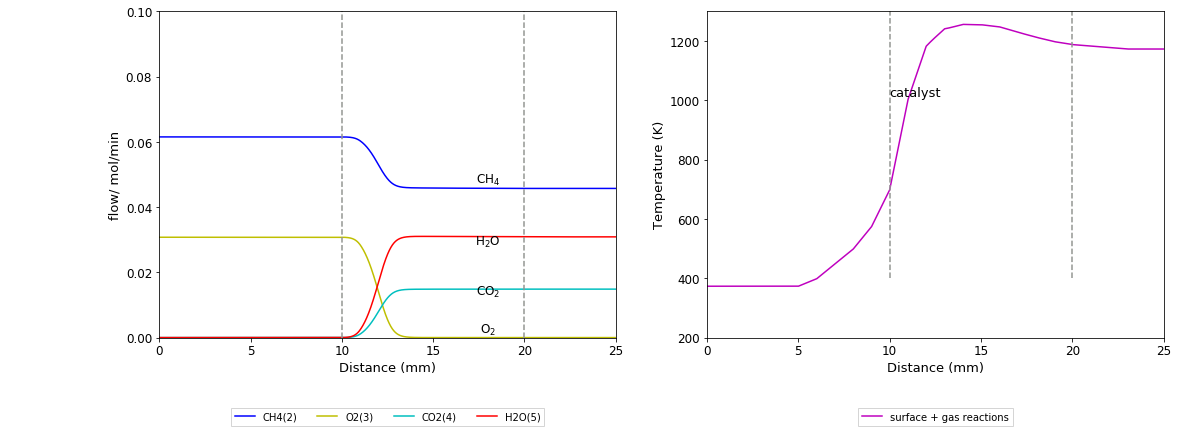

In [212]:
r = 1.0
fo2 = 0.208/(2.*r+1+79/21)
fch4 = 2*fo2*r
far = 79*fo2/21

moles_in = [fch4,fo2,far]

a = monolithFull(gas,surf,temp_array,moles_in)
plotflow(a)

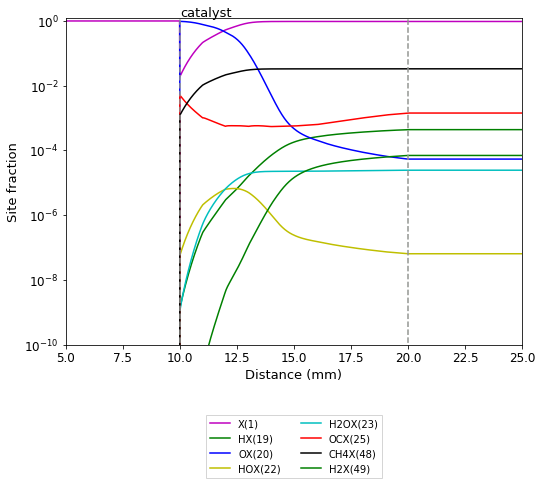

In [132]:
plotSurf(a)

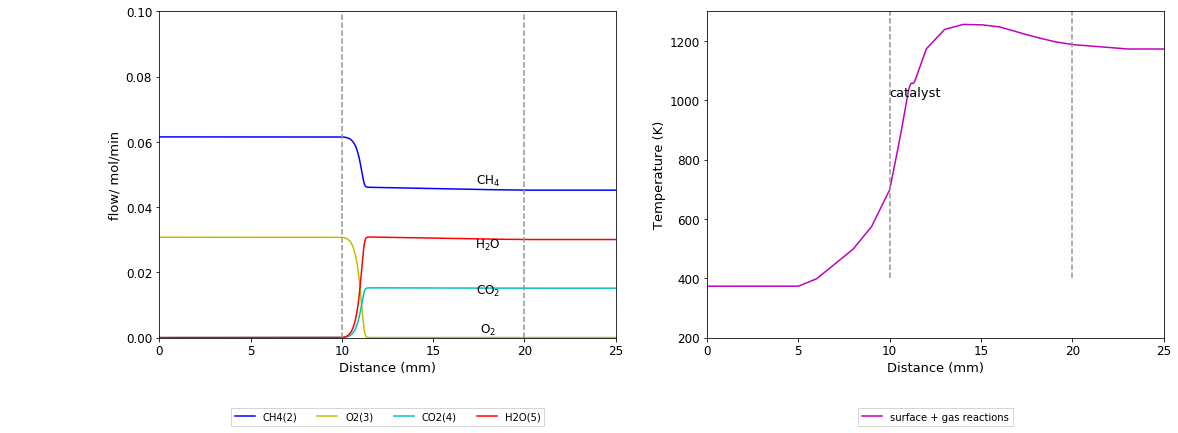

In [136]:
r = 1.0
fo2 = 0.208/(2.*r+1+79/21)
fch4 = 2*fo2*r
far = 79*fo2/21

moles_in = [fch4,fo2,far]

a2 = monolithFull(gas,surf,temp_array,moles_in)
plotflow(a2)

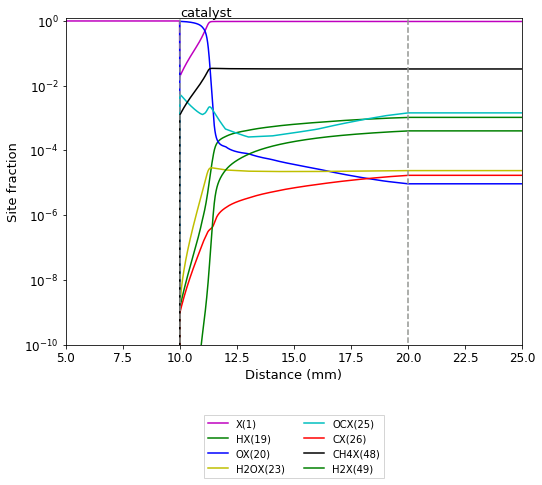

In [137]:
plotSurf(a2)

In [209]:
gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
dk = 1.0e-2
old_data = [gas_out, gas_names, dist_array, temp_array]
reactions, sensitivity1, sensitivity2, sensitivity3, sensitivity4, sensitivity5, sensitivity6, sensitivity7, sensitivity8, sensitivity9, sensitivity10, sensitivity11, sensitivity12, sensitivity13 = sensitivity(gas, surf, old_data, temp_array, dk)

0 CH4(2) + X(1) <=> CH4X(48) -0.000 -0.000
1 O2(3) + 2 X(1) <=> 2 OX(20) 0.024 0.026
2 H2(6) + 2 X(1) <=> 2 HX(19) 0.001 0.001
3 H(12) + X(1) <=> HX(19) 0.002 0.002
4 HX(19) + OX(20) <=> HOX(22) + X(1) 0.000 0.000
5 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.002 0.002
6 OH(17) + X(1) <=> HOX(22) 0.004 0.004
7 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) 0.127 0.131
8 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) 0.660 0.677
9 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000 0.000
10 CH3(10) + X(1) <=> CH3X(21) -0.000 -0.000
11 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000 0.000
12 CH2X(27) + HX(19) <=> CH3X(21) + X(1) -0.000 -0.000
13 CH2X(27) + HOX(22) <=> CH3X(21) + OX(20) -0.000 -0.000
14 CHX(28) + HX(19) <=> CH2X(27) + X(1) -0.000 -0.000
15 CHX(28) + HOX(22) <=> CH2X(27) + OX(20) -0.000 -0.000
16 2 CH2X(27) <=> CH3X(21) + CHX(28) -0.000 -0.000
17 CHX(28) + X(1) <=> CX(26) + HX(19) -0.000 -0.000
18 CX(26) + H2(6) <=> CH2X(27) -0.000 -0.000
19 CX(26) + HOX(22) <=> CHX(28) + OX(20) -0.000 -0.000
20 CH3X(

In [213]:
output = []
for x in range(len(reactions)):
    output.append([reactions[x], sensitivity1[x], sensitivity2[x], sensitivity3[x], 
                     sensitivity4[x], sensitivity5[x], sensitivity6[x], sensitivity7[x], 
                     sensitivity8[x], sensitivity9[x], sensitivity10[x], sensitivity11[x],
                     sensitivity12[x], sensitivity13[x]])

In [216]:
sorted_output = sorted(output, key=sortO2conv)
for x in sorted_output:
    if abs(x[-1]) >= 1e-2:
        print x[0], x[-1]
# print sorted_output_v

In [218]:
def import_sensitivities(ratio, file_location=False, thermo=False):
    """
    Ratio is the C/O starting gas ratio
    file_location is the LSR C and O binding energy, fasle to load the base case
    thermo is either False to load reaction sensitivities or True to load thermo sensitivities
    """
    try:
        # load in the sensitivity csv files
        if file_location is False:
            if thermo is False:
                data = pd.read_csv('./sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
            else:
                data = pd.read_csv('./sensitivities/' + str(ratio) + 'ThermoSensitivity.csv')
        else:
            if thermo is False:
                data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
            else:
                data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(ratio) + 'ThermoSensitivity.csv')
        data = data.get_values()
        data = data.tolist()
        return data
    except:
        if thermo is False:
            print('Cannot find ' + str(ratio) + 'RxnSensitivity.csv for:    ' + file_location)
        else:
            print('Cannot find ' + str(ratio) + 'ThermoSensitivity.csv for: ' + file_location)
        # try loading the reactions from a different ratio to use as placeholders
        try_ratios = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
        for r in try_ratios:
            try:
                if file_location is False:
                    if thermo is False:
                        data = pd.read_csv('./sensitivities/' + str(r) + 'RxnSensitivity.csv')
                    else:
                        data = pd.read_csv('./sensitivities/' + str(r) + 'ThermoSensitivity.csv')
                else:
                    if thermo is False:
                        data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(r) + 'RxnSensitivity.csv')
                    else:
                        data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(r) + 'ThermoSensitivity.csv')
                data = data.get_values()
                fakedata = data
#                 fakedata = np.zeros_like(data, dtype=float)
                for x in range(len(data)):
                    for y in xrange(2,15):
                        fakedata[x][y] = 0.
                return fakedata.tolist()
                break
            except:
                continue

In [277]:
ratios = [.6, .7, .8, .9, 1., 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2., 2.2, 2.4, 2.6]  # 15 items

allrxndata = []  # where all rxn sens itivities will be stored
# allthermodata = []  # where all thermo sensitivities will be stored
for ratio in ratios:
    allrxndata.append(import_sensitivities(ratio, file_location=False))
#     thermodata.append(import_sensitivities(ratio, file_location=False, thermo=True))

def sort(e):  # sort by syngas yield selectivity
    return e[2]
def sortCH4conv(e): # sort by methane conversion
    return e[7]
def sortO2conv(e):
    return e[-1]
def sortaddedO2(e):
    return e[1]

In [248]:
# looking at just O2 conversion sensitivities
for r in range(len(allrxndata)):
    sorted_output = sorted(allrxndata[r], key=sortO2conv)
    print 'ratio {}'.format(ratios[r])
    for x in sorted_output:
        if abs(x[-1]) >= 1e-1:
            print x[1], x[-1]
            

ratio 0.6
ratio 0.7
C=O + 2 [Pt] <=> O=C[Pt] + [Pt] 0.387363833686
O=C[Pt] + O=[Pt] <=> O[Pt] + O=C=[Pt] 0.38939537748
[CH3] + [Pt] <=> C[Pt] 0.393981705072
C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt] 0.409500350416
C + O[Pt] + [Pt] <=> C[Pt] + O.[Pt] 0.409738340626
C~[Pt] + [H][H] <=> C=[Pt] 0.41021441164
C=[Pt] + [Pt] <=> C[Pt] + [Pt] 0.410215417801
2 C=[Pt] <=> C[Pt] + C#[Pt] 0.410330869644
O[Pt] + [Pt] <=> O.[Pt] + [Pt] 0.410337456488
[Pt] + O=[Pt] <=> O[Pt] + [Pt] 0.410354998283
C~[Pt] + O=[Pt] <=> O=C=[Pt] + [Pt] 0.41125192954
C + O=[Pt] + [Pt] <=> C[Pt] + O[Pt] 0.429145231981
[O][O] + 2 [Pt] <=> 2 O=[Pt] 0.5873334072
CC + 2 [Pt] <=> 2 C[Pt] 1.33230607073
[H][H] + 2 [Pt] <=> 2 [Pt] 1.3327776253
[CH]=O + [Pt] <=> O=C[Pt] 1.35448220421
C#[Pt] + [Pt] <=> C=[Pt] + [Pt] 1.35448224386
O=C=O.[Pt] + [Pt] <=> O[Pt] + O=C=[Pt] 1.35464488785
ratio 0.8
O=C=[Pt] + O=[Pt] <=> O=C=O.[Pt] + [Pt] -0.217908091404
C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt] -0.199753017907
[CH]=O + [Pt] <=> O=C[Pt] -0.19975299125

In [264]:
o2_sens_data = []
for reaction in range(len(allrxndata[0])):  # number of reactions
    added_sens_values = 0
    for ratio in range(len(allrxndata)):  # numebr of ratios
        surf_reaction = allrxndata[ratio][reaction][1]
        sensvalue = allrxndata[ratio][reaction][-1]  # the individual sensitivities
        added_sens_values = added_sens_values + sensvalue
    o2_sens_data.append([surf_reaction, added_sens_values])

In [279]:
sorted_added_o2 =  sorted(o2_sens_data, key=sortaddedO2)
for x in sorted_added_o2:
    print x

['C[Pt] + C~[Pt] <=> C=[Pt] + C#[Pt]', -2.504751799050264]
['O=C=O + [Pt] <=> O=C=O.[Pt]', -2.42640555915103]
['O + [Pt] <=> O.[Pt]', -2.037928184759411]
['CO + 2 [Pt] <=> C[Pt] + O[Pt]', -1.9468986543882318]
['2 C=[Pt] <=> C[Pt] + C#[Pt]', -1.8845889295263447]
['[OH] + [Pt] <=> O[Pt]', -1.705403368796105]
['C#[Pt] + [Pt] <=> C~[Pt] + [Pt]', -1.6680024160518647]
['C=O + 2 [Pt] <=> O=C[Pt] + [Pt]', -1.6560193613769045]
['[H][H] + [Pt] <=> [H][H].[Pt]', -1.6078641432580254]
['[CH3] + [Pt] <=> C[Pt]', -1.3735370731904093]
['[C-]#[O+] + [Pt] <=> O=C=[Pt]', -1.3025872829200076]
['O=C[Pt] + C~[Pt] <=> C#[Pt] + O=C=[Pt]', -1.2441210692720683]
['C=[Pt] + O=C[Pt] <=> C[Pt] + O=C=[Pt]', -1.0470433473561607]
['C=[Pt] + O[Pt] <=> C[Pt] + O=[Pt]', -0.9448945394413155]
['C#[Pt] + O[Pt] <=> C=[Pt] + O=[Pt]', -0.9177571990208757]
['O=C[Pt] + C#[Pt] <=> C=[Pt] + O=C=[Pt]', -0.8682577478434204]
['O=C[Pt] + [Pt] <=> [Pt] + O=C=[Pt]', -0.8226279632122118]
['[Pt] + O=[Pt] <=> O[Pt] + [Pt]', -0.771923034872

# deutschmann
as published in 2006

In [159]:
gas_deutschmann = ct.Solution('../cpox-cti/Deutschmann_methane_pox_on_pt-reverse_included.cti', 'gas')
surf_deutschmann = ct.Interface('../cpox-cti/Deutschmann_methane_pox_on_pt-reverse_included.cti', 'Pt_surf', [gas_deutschmann])

print("This mechanism contains {} gas reactions and {} surface reactions".format(gas_deutschmann.n_reactions, surf_deutschmann.n_reactions))

i_ar = gas_deutschmann.species_index('AR')
i_ch4 = gas_deutschmann.species_index('CH4')
i_o2 = gas_deutschmann.species_index('O2')
i_co2 = gas_deutschmann.species_index('CO2')
i_h2o = gas_deutschmann.species_index('H2O')
i_h2 = gas_deutschmann.species_index('H2')
i_co = gas_deutschmann.species_index('CO')

cat_area_per_vol = 1600.

This mechanism contains 0 gas reactions and 36 surface reactions


  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    1.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    2.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    3.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    4.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    5.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    6.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    7.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    8.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    9.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
   10.000000    0.290378    0.139726    0.003564   0.000083   0.006151   0.004774
   11.000000    

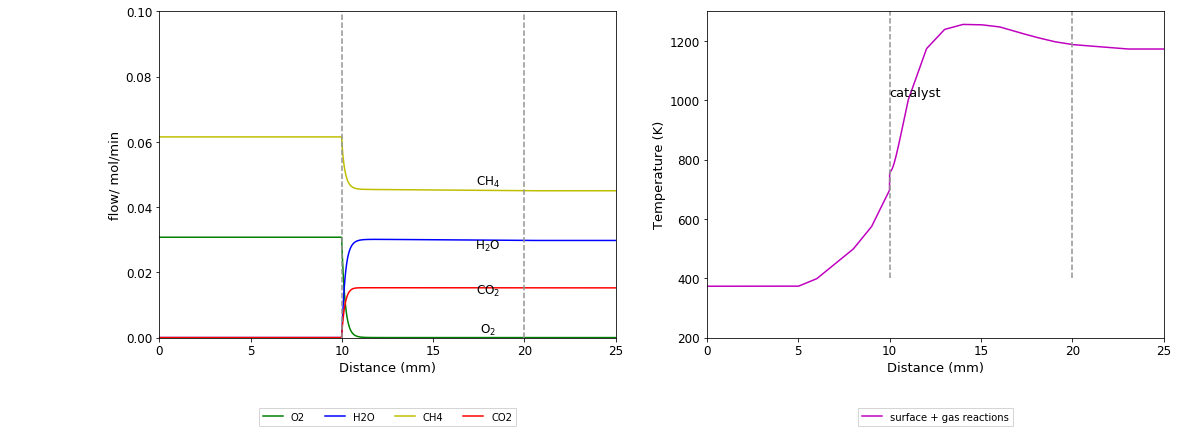

In [160]:
ratio = 1.0
fo2 = 1 / (2. * ratio + 1 + 79 / 21)
fch4 = 2 * fo2 * ratio
far = 79 * fo2 / 21
ratio_in = [fch4, fo2, far]  # mol fractions

d = monolithDeutschmann(gas_deutschmann, surf_deutschmann, temp_array, ratio_in, verbose=True)
gas_out_deutschmann, surf_out_deutschmann, gas_names_deutschmann, surf_names_deutschmann, dist_array_deutschmann, T_array_deutschmann = d
plotflow(d)

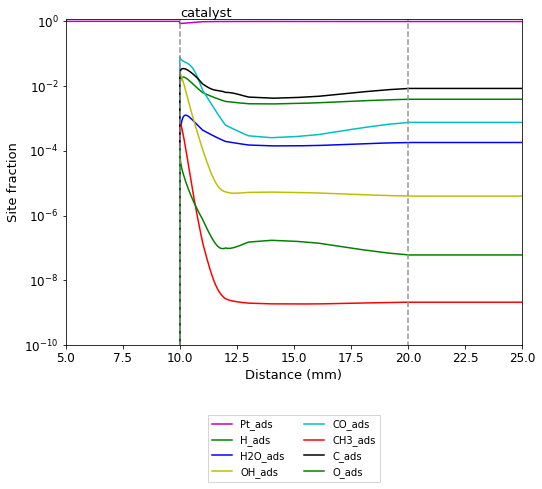

In [161]:
plotSurf(d)

In [119]:
cat_area_per_vol = 10000

  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    1.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    2.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    3.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    4.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    5.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    6.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    7.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    8.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    9.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
   10.000000    0.274878    0.113621    0.006235   0.004194   0.032474   0.015161
   11.000000    

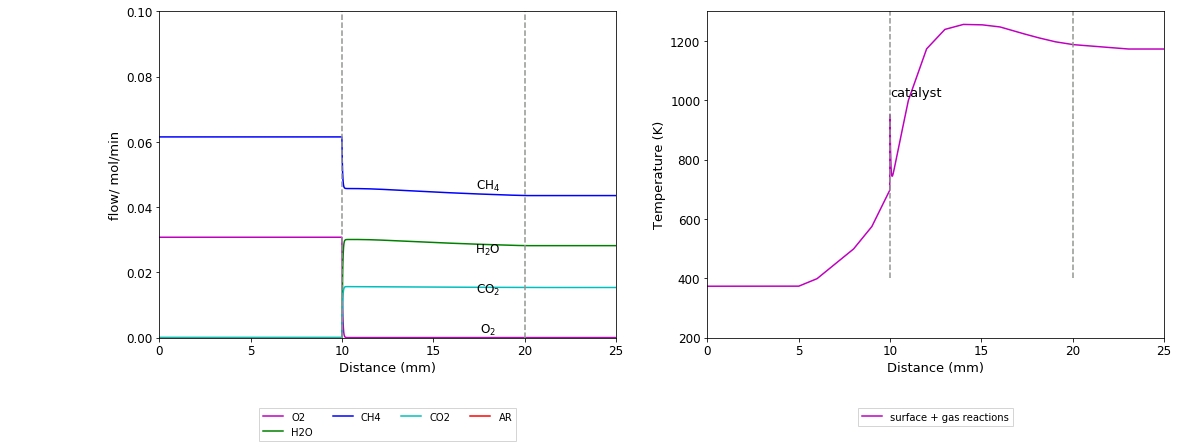

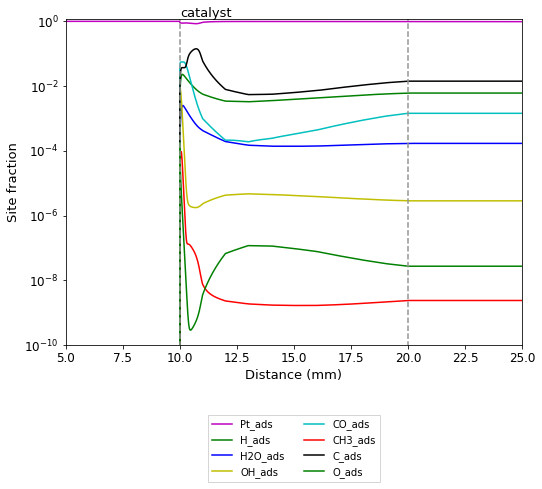

In [138]:
ratio = 1.0
fo2 = 1 / (2. * ratio + 1 + 79 / 21)
fch4 = 2 * fo2 * ratio
far = 79 * fo2 / 21
ratio_in = [fch4, fo2, far]  # mol fractions

d2 = monolithDeutschmann(gas_deutschmann, surf_deutschmann, temp_array, ratio_in, verbose=True)
gas_out_deutschmann, surf_out_deutschmann, gas_names_deutschmann, surf_names_deutschmann, dist_array_deutschmann, T_array_deutschmann = d2
plotflow(d2)
plotSurf(d2)


In [162]:
dk = 1.0e-2
deutschmann_old_data = [gas_out_deutschmann, gas_names_deutschmann, dist_array_deutschmann, temp_array]
# species on surface are the reactions
species_on_surface_d, sensitivity1_d, sensitivity2_d, sensitivity3_d, sensitivity4_d, sensitivity5_d, sensitivity6_d, sensitivity7_d, sensitivity8_d, sensitivity9_d, sensitivity10_d, sensitivity11_d, sensitivity12_d = sensitivity_deutschmann(gas_deutschmann, surf_deutschmann, deutschmann_old_data, temp_array, dk)

0 H2 + 2 Pt_ads => 2 H_ads -0.396 -0.434
1 O2 + 2 Pt_ads => 2 O_ads -0.333 -0.341
2 CH4 + 2 Pt_ads => CH3_ads + H_ads 0.073 0.078
3 CH4 + O_ads + Pt_ads => CH3_ads + OH_ads 0.000 0.000
4 CH4 + OH_ads + Pt_ads => CH3_ads + H2O_ads 0.696 0.752
5 H2O + Pt_ads => H2O_ads 0.237 0.255
6 CO2 + Pt_ads => CO2_ads 0.004 0.004
7 CO + Pt_ads => CO_ads -0.129 -0.134
8 2 H_ads => H2 + 2 Pt_ads 0.343 0.376
9 2 O_ads => O2 + 2 Pt_ads 0.000 0.000
10 H2O_ads => H2O + Pt_ads -0.235 -0.253
11 CO_ads => CO + Pt_ads 0.131 0.137
12 CO2_ads => CO2 + Pt_ads -0.004 -0.004
13 C_ads + O_ads => CO_ads + Pt_ads 0.000 0.002
14 CO_ads + Pt_ads => C_ads + O_ads -0.000 -0.000
15 CO_ads + O_ads => CO2_ads + Pt_ads -0.000 -0.000
16 CO2_ads + Pt_ads => CO_ads + O_ads 0.000 0.000
17 CO_ads + OH_ads => CO2_ads + H_ads -0.153 -0.159
18 CO2_ads + H_ads => CO_ads + OH_ads 0.004 0.004
19 CH3_ads + Pt_ads => CH2_ads + H_ads 0.115 0.125
20 CH2_ads + H_ads => CH3_ads + Pt_ads -0.051 -0.056
21 CH2_ads + Pt_ads => CH_ads + H_ads 0.0

In [170]:
output_d = []
for x in range(len(species_on_surface_d)):
    output_d.append([species_on_surface_d[x], sensitivity1_d[x], sensitivity2_d[x], 
                   sensitivity3_d[x], sensitivity4_d[x], sensitivity5_d[x], 
                   sensitivity6_d[x], sensitivity7_d[x], sensitivity8_d[x], 
                   sensitivity9_d[x], sensitivity10_d[x], sensitivity11_d[x], 
                   sensitivity12_d[x]])

In [174]:
k = (pd.DataFrame.from_dict(data=output_d, orient='columns'))
k.columns = ['Reaction', 'SYNGAS Selec', 'SYNGAS Yield', 'CO Selectivity', 'CO % Yield', 'H2 Selectivity', 'H2 % Yield',
            'CH4 Conversion', 'H2O+CO2 Selectivity', 'H2O+CO2 yield', 'Exit Temp', 'Peak Temp',
            'Dist to peak temp']
k

,Reaction,SYNGAS Selec,SYNGAS Yield,CO Selectivity,CO % Yield,H2 Selectivity,H2 % Yield,CH4 Conversion,H2O+CO2 Selectivity,H2O+CO2 yield,Exit Temp,Peak Temp,Dist to peak temp
0,H2 + 2 Pt_ads => 2 H_ads,-3.958688e-01,-4.335250e-01,6.277851e-02,2.494892e-02,-7.164326e-01,-7.539675e-01,-3.780585e-02,4.173111e-02,3.909479e-03,-1.938147e-13,-0.000720,0.0
1,O2 + 2 Pt_ads => 2 O_ads,-3.333519e-01,-3.414498e-01,-1.193621e+00,-1.201649e+00,2.679190e-01,2.597723e-01,-8.124990e-03,2.521507e-02,1.708803e-02,3.101035e-13,-0.000719,0.0
2,CH4 + 2 Pt_ads => CH3_ads + H_ads,7.283728e-02,7.822678e-02,7.112374e-02,7.651315e-02,7.403493e-02,7.942449e-02,5.385575e-03,-7.019918e-03,-1.634720e-03,7.752587e-14,-0.000722,0.0
3,CH4 + O_ads + Pt_ads => CH3_ads + OH_ads,3.887906e-05,4.179433e-05,3.583437e-05,3.874964e-05,4.100709e-05,4.392236e-05,2.915273e-06,-3.764207e-06,-8.489339e-07,1.356703e-13,-0.000720,0.0
4,CH4 + OH_ads + Pt_ads => CH3_ads + H2O_ads,6.960836e-01,7.519096e-01,4.724776e-01,5.281796e-01,8.523693e-01,9.082819e-01,5.544004e-02,-6.873737e-02,-1.333545e-02,-5.814440e-14,-0.000721,0.0
5,H2O + Pt_ads => H2O_ads,2.374758e-01,2.552228e-01,2.243317e-01,2.420764e-01,2.466627e-01,2.644113e-01,1.770493e-02,-2.294764e-02,-5.246775e-03,0.000000e+00,-0.000725,0.0
6,CO2 + Pt_ads => CO2_ads,4.219547e-03,4.381250e-03,1.201690e-02,1.217861e-02,-1.230280e-03,-1.068586e-03,1.616960e-04,-3.437916e-04,-1.820961e-04,-2.713405e-13,-0.000720,0.0
7,CO + Pt_ads => CO_ads,-1.287419e-01,-1.344785e-01,-3.240385e-01,-3.297639e-01,7.757356e-03,2.012920e-03,-5.743989e-03,1.082864e-02,5.084028e-03,-1.162888e-13,-0.000720,0.0
8,2 H_ads => H2 + 2 Pt_ads,3.432017e-01,3.756862e-01,-3.206192e-02,3.010524e-04,6.054859e-01,6.380553e-01,3.237335e-02,-3.600104e-02,-3.639344e-03,-9.690733e-14,-0.000720,0.0
9,2 O_ads => O2 + 2 Pt_ads,7.503055e-10,1.046989e-09,4.539810e-10,7.507026e-10,9.574066e-10,1.254119e-09,2.966971e-10,-3.253815e-10,-2.868267e-11,9.690733e-14,-0.000720,0.0


In [214]:
def sort(e):  # sort by syngas yield selectivity
    return e[2]
def sortCH4conv(e): # sort by methane conversion
    return e[7]
def sortO2conv(e):
    return e[-1]

In [182]:
print sensitivity2_d.index(max(sensitivity2_d)) # max syngas yield sensitivity
print sensitivity2_d.index(min(sensitivity2_d)) # min syngas yield sensitivity

4
32


In [204]:
sorted_output_d = sorted(output_d, key=sort)
for x in sorted_output_d:
    if abs(x[2]) >= 1e-2:
        print x[0], x[2]
# print sorted_output_v

H_ads + OH_ads => H2O_ads + Pt_ads -0.5784751091294734
H2 + 2 Pt_ads => 2 H_ads -0.433524960001838
O2 + 2 Pt_ads => 2 O_ads -0.34144979962644867
H2O_ads => H2O + Pt_ads -0.25298519958361393
CO_ads + OH_ads => CO2_ads + H_ads -0.15931252947439623
CO + Pt_ads => CO_ads -0.13447850187138033
CH3_ads + H_ads => CH4 + 2 Pt_ads -0.12529033291357072
CH2_ads + H_ads => CH3_ads + Pt_ads -0.05614047925154094
2 OH_ads => H2O_ads + O_ads -0.010039150760297261
CH2_ads => C_ads + H2 0.0559690791528283
CH4 + 2 Pt_ads => CH3_ads + H_ads 0.07822678059501119
CH3_ads + Pt_ads => CH2_ads + H_ads 0.12539319688407422
CO_ads => CO + Pt_ads 0.13674687658553833
H2O_ads + Pt_ads => H_ads + OH_ads 0.254682872539391
H2O + Pt_ads => H2O_ads 0.2552228062592298
2 H_ads => H2 + 2 Pt_ads 0.3756861730937196
CH4 + OH_ads + Pt_ads => CH3_ads + H2O_ads 0.7519095935529596


# vlachos

In [164]:
gas_vlachos = ct.Solution('../cpox-cti/vlachos_methane_pox_on_pt_fwd_rev-190519.cti', 'gas')
surf_vlachos = ct.Interface('../cpox-cti/vlachos_methane_pox_on_pt_fwd_rev-190519.cti', 'Pt_surf', [gas_vlachos])

print("This mechanism contains {} gas reactions and {} surface reactions".format(gas_vlachos.n_reactions, surf_vlachos.n_reactions))

i_ar = gas_vlachos.species_index('AR')
i_ch4 = gas_vlachos.species_index('CH4')
i_o2 = gas_vlachos.species_index('O2')
i_co2 = gas_vlachos.species_index('CO2')
i_h2o = gas_vlachos.species_index('H2O')
i_h2 = gas_vlachos.species_index('H2')
i_co = gas_vlachos.species_index('CO')

This mechanism contains 0 gas reactions and 103 surface reactions


  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    1.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    2.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    3.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    4.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    5.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    6.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    7.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    8.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    9.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
   10.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
   11.000000    

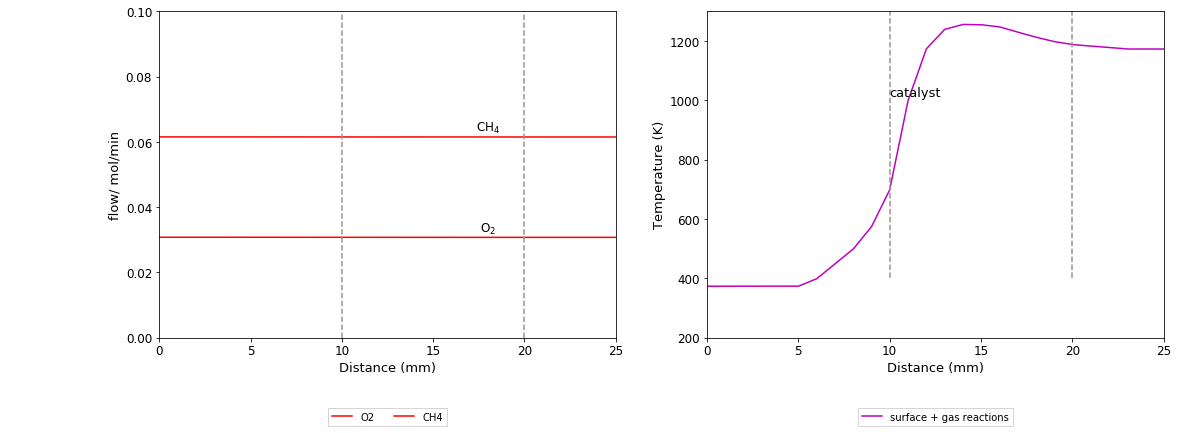

In [165]:
ratio = 1.0
fo2 = 1 / (2. * ratio + 1 + 79 / 21)
fch4 = 2 * fo2 * ratio
far = 79 * fo2 / 21
ratio_in = [fch4, fo2, far]  # mol fractions

v = monolithDeutschmann(gas_vlachos, surf_vlachos, temp_array, ratio_in, verbose=True)
gas_out_vlachos, surf_out_vlachos, gas_names_vlachos, surf_names_vlachos, dist_array_vlachos, T_array_vlachos = v
plotflow(v)

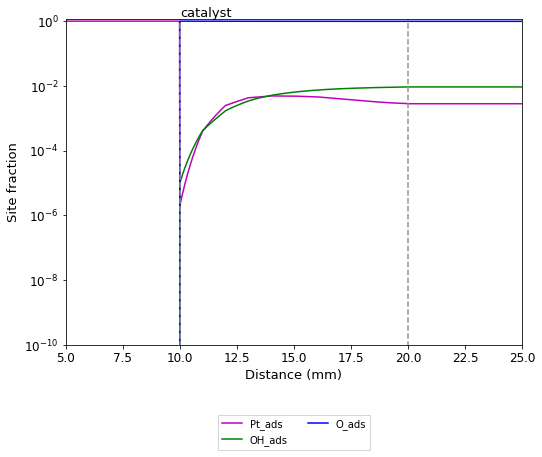

In [166]:
plotSurf(v)

  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    1.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    2.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    3.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    4.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    5.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    6.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    7.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    8.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    9.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
   10.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
   11.000000    

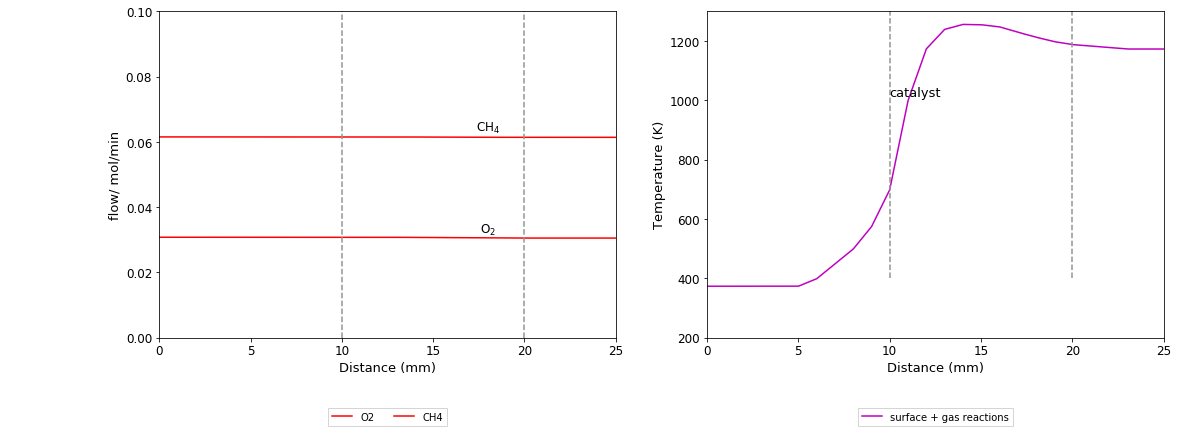

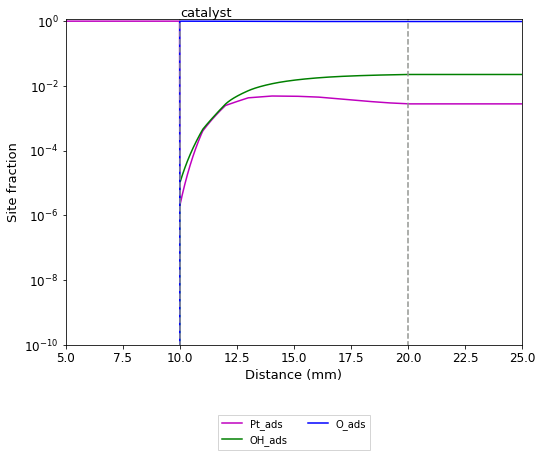

In [139]:
cat_area_per_vol = 10000
ratio = 1.0
fo2 = 1 / (2. * ratio + 1 + 79 / 21)
fch4 = 2 * fo2 * ratio
far = 79 * fo2 / 21
ratio_in = [fch4, fo2, far]  # mol fractions

v2 = monolithDeutschmann(gas_vlachos, surf_vlachos, temp_array, ratio_in, verbose=True)
gas_out_vlachos, surf_out_vlachos, gas_names_vlachos, surf_names_vlachos, dist_array_vlachos, T_array_vlachos = v2
plotflow(v2)
plotSurf(v2)

In [167]:
dk = 1.0e-2
vlachos_old_data = [gas_out_vlachos, gas_names_vlachos, dist_array_vlachos, temp_array]
species_on_surface_v, sensitivity1_v, sensitivity2_v, sensitivity3_v, sensitivity4_v, sensitivity5_v, sensitivity6_v, sensitivity7_v, sensitivity8_v, sensitivity9_v, sensitivity10_v, sensitivity11_v, sensitivity12_v = sensitivity_deutschmann(gas_vlachos, surf_vlachos, vlachos_old_data, temp_array, dk)

0 O2 + 2 Pt_ads => 2 O_ads 0.237 -0.729
1 O + Pt_ads => O_ads 0.000 -0.000
2 CO + Pt_ads => CO_ads -0.488 -0.522
3 CO2 + Pt_ads => CO2_ads 0.000 0.000
4 H2 + 2 Pt_ads => 2 H_ads -0.000 -0.000
5 OH + Pt_ads => OH_ads 0.000 -0.000
6 H2O + Pt_ads => H2O_ads 0.003 -0.002
7 H + Pt_ads => H_ads -0.000 -0.000
8 COOH + Pt_ads => HOCXO -0.000 0.000
9 HCOO + 2 Pt_ads => OXCHOX -0.000 -0.000
10 C + Pt_ads => C_ads -0.000 -0.000
11 CH + Pt_ads => CH_ads -0.000 -0.000
12 CH2 + Pt_ads => CH2_ads -0.000 -0.000
13 CH3 + Pt_ads => CH3_ads 0.000 0.000
14 CH4 + 2 Pt_ads => CH3_ads + H_ads 0.003 1.000
15 H3C-OH + Pt_ads => H3C-OH_ads -0.000 -0.000
16 H2C-O + Pt_ads => H2C-O_ads -0.000 -0.000
17 HCO + Pt_ads => COH_ads -0.000 0.000
18 H2C-OH + Pt_ads => H2C-OH_ads -0.000 -0.000
19 2 O_ads => O2 + 2 Pt_ads -0.237 0.731
20 O_ads => O + Pt_ads -0.000 0.000
21 CO_ads => CO + Pt_ads 0.550 0.589
22 CO2_ads => CO2 + Pt_ads -0.000 -0.000
23 CO2_ads + Pt_ads => CO_ads + O_ads 0.000 0.000
24 CO_ads + O_ads => CO2_ad

In [185]:
output_v = []
for x in range(len(species_on_surface_v)):
    output_v.append([species_on_surface_v[x], sensitivity1_v[x], sensitivity2_v[x],
                     sensitivity3_v[x], sensitivity4_v[x], sensitivity5_v[x], 
                     sensitivity6_v[x], sensitivity7_v[x], sensitivity8_v[x], 
                     sensitivity9_v[x], sensitivity10_v[x], sensitivity11_v[x], 
                     sensitivity12_v[x]])
j = (pd.DataFrame.from_dict(data=output_v, orient='columns'))
j.columns = ['Reaction', 'SYNGAS Selec', 'SYNGAS Yield', 'CO Selectivity', 'CO % Yield', 'H2 Selectivity', 'H2 % Yield',
            'CH4 Conversion', 'H2O+CO2 Selectivity', 'H2O+CO2 yield', 'Exit Temp', 'Peak Temp',
            'Dist to peak temp']
j

,Reaction,SYNGAS Selec,SYNGAS Yield,CO Selectivity,CO % Yield,H2 Selectivity,H2 % Yield,CH4 Conversion,H2O+CO2 Selectivity,H2O+CO2 yield,Exit Temp,Peak Temp,Dist to peak temp
0,O2 + 2 Pt_ads => 2 O_ads,2.369941e-01,-7.292521e-01,2.369941e-01,-7.292521e-01,-3.349516e-01,-1.295684e+00,-9.639617e-01,-9.801502e-02,-1.061032e+00,-1.744332e-13,0.000175,0.0
1,O + Pt_ads => O_ads,7.282354e-05,-4.453525e-07,7.282354e-05,-4.453524e-07,7.244776e-05,-8.211274e-07,-7.326884e-05,7.265499e-05,-6.139007e-07,-1.938147e-14,0.000176,0.0
2,CO + Pt_ads => CO_ads,-4.880011e-01,-5.224107e-01,-4.880011e-01,-5.224107e-01,3.496105e-02,3.705888e-04,-3.457837e-02,2.015078e-01,1.668598e-01,1.356703e-13,0.000176,0.0
3,CO2 + Pt_ads => CO2_ads,8.391833e-09,1.099985e-08,8.391834e-09,1.099985e-08,9.258236e-09,1.186625e-08,2.608011e-09,1.200687e-09,3.808681e-09,-2.907220e-13,0.000176,0.0
4,H2 + 2 Pt_ads => 2 H_ads,-7.116376e-08,-8.050042e-08,9.188540e-09,-1.481233e-10,-1.149394e+00,-1.149395e+00,-9.336666e-09,3.646778e-08,2.713111e-08,-1.938147e-13,0.000176,0.0
5,OH + Pt_ads => OH_ads,7.748679e-08,-3.309283e-09,7.748676e-08,-3.309300e-09,5.710247e-07,4.902287e-07,-8.079608e-08,2.887357e-07,2.079396e-07,-3.876293e-14,0.000176,0.0
6,H2O + Pt_ads => H2O_ads,3.213415e-03,-2.196044e-03,3.213349e-03,-2.196110e-03,9.497905e-01,9.443299e-01,-5.409285e-03,-1.327769e-03,-6.736983e-03,0.000000e+00,0.000176,0.0
7,H + Pt_ads => H_ads,-2.866346e-11,-2.373079e-10,-2.866346e-11,-2.372912e-10,1.650357e-09,1.441723e-09,-2.086499e-10,-1.274500e-10,-3.361139e-10,3.876293e-14,0.000176,0.0
8,COOH + Pt_ads => HOCXO,-3.359397e-09,3.101420e-11,-3.359397e-09,3.101420e-11,1.041358e-08,1.380400e-08,3.390407e-09,4.815614e-09,8.206009e-09,-3.488664e-13,0.000176,0.0
9,HCOO + 2 Pt_ads => OXCHOX,-9.971166e-10,-1.625531e-10,-9.971167e-10,-1.625532e-10,3.569447e-09,4.404013e-09,8.345545e-10,1.470020e-09,2.304556e-09,2.131961e-13,0.000176,0.0


In [200]:
sorted_output_v = sorted(output_v, key=sort)
for x in sorted_output_v:
    if abs(x[2]) >= 1e-3:
        print x[0],x[2]
# print sorted_output_v

O2 + 2 Pt_ads => 2 O_ads -0.7292521410242757
CO_ads + O_ads => CO2_ads + Pt_ads -0.5891758443437487
CO + Pt_ads => CO_ads -0.5224107074249423
H2O + Pt_ads => H2O_ads -0.0021960439193225417
H2O_ads + O_ads => 2 OH_ads -0.002154097028654575
H2O_ads => H2O + Pt_ads 0.002185822397124724
2 OH_ads => H2O_ads + O_ads 0.002520746079952831
CO_ads => CO + Pt_ads 0.5891426979334163
2 O_ads => O2 + 2 Pt_ads 0.7309464425470854
CH4 + 2 Pt_ads => CH3_ads + H_ads 1.0002338884505544


# thermo changing

In [61]:
surf.species_names

['X(1)',
 'HX(19)',
 'OX(20)',
 'CH3X(21)',
 'HOX(22)',
 'H2OX(23)',
 'CO2X(24)',
 'OCX(25)',
 'CX(26)',
 'CH2X(27)',
 'CHX(28)',
 'CH4X(48)',
 'H2X(49)',
 'COX(50)',
 'CHOX(53)']

In [62]:
surf.species('OCX(25)')

<Species OCX(25)>

In [95]:
def adjust_thermo(changes_dict):
    """
    Give it a dictionary of species names and Delta H (kJ/mol) changes.
    """
    original_dict = dict()
    for species_name, dH in changes_dict.items():
        
        print species_name
        dk = dH*1000 / 8.314  # for the thermo loop, 'dk' is in fact (delta H / R)

        m = surf.species_index(species_name)
        s = surf.species(m)
        print "was", s.thermo.h(300)
        original_coeffs = s.thermo.coeffs
        perturbed_coeffs = np.ones_like(original_coeffs)
        perturbed_coeffs[:] = original_coeffs
        perturbed_coeffs[6] = original_coeffs[6] + dk
        perturbed_coeffs[13] = original_coeffs[13] + dk

        s.thermo = ct.NasaPoly2(100.000, 5000.000, ct.one_atm, perturbed_coeffs)
        surf.modify_species(m, s)
        
        original_dict[species_name] = original_coeffs

        print "now", s.thermo.h(300)
        
    return original_dict

def reset_thermo(original_dict):
    "Put the given original parameters back"
    for species_name, original_coeffs in original_dict.items():
        print species_name
        m = surf.species_index(species_name)
        s = surf.species(m)
        s.thermo = ct.NasaPoly2(100.000, 5000.000, ct.one_atm, original_coeffs)
        surf.modify_species(m, s)
        print "is back to", s.thermo.h(300)

In [103]:
original_dict = adjust_thermo({
     'HX(19)': 0,
     'OCX(25)': 60,  # was good
     'OX(20)': 40,
     'H2OX(23)': 0,
     'HOX(22)': 60})

OX(20)
was -140451552.048
now -100449328.81
HX(19)
was -26925853.9291
now -26925853.9291
H2OX(23)
was -263383455.22
now -263383455.22
HOX(22)
was -155784500.324
now -95781165.4674
OCX(25)
was -281361922.959
now -221358588.102


In [107]:
reset_thermo(original_dict)

OX(20)
is back to -140451552.048
HX(19)
is back to -26925853.9291
OCX(25)
is back to -281361922.959
HOX(22)
is back to -155784500.324
H2OX(23)
is back to -263383455.22


  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2
    0.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    1.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    2.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    3.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    4.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    5.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    6.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    7.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    8.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
    9.000000    0.295775    0.147887    0.000000   0.000000   0.000000   0.000000
   10.000000    0.295772    0.147884    0.000000   0.000001   0.000004   0.000001
   11.000000    

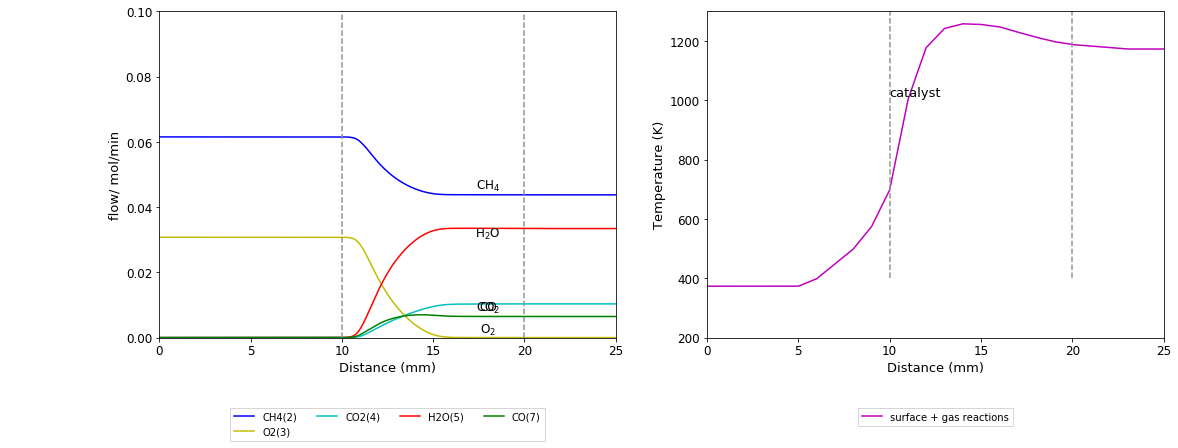

In [104]:
r = 1.0
fo2 = 0.208/(2.*r+1+79/21)
fch4 = 2*fo2*r
far = 79*fo2/21

moles_in = [fch4,fo2,far]

a = monolithFull(gas,surf,temp_array,moles_in,verbose=True)
plotflow(a)

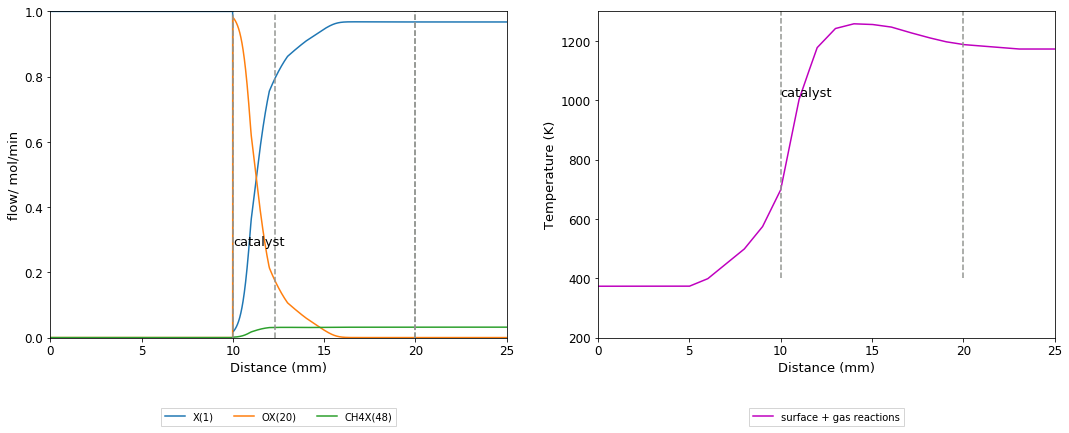

In [105]:
gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a

fig, axs = plt.subplots(1,2)

for i in range(len(surf_out[0,:])):
    if surf_out[:,i].max() > 5.e-3:
        axs[0].plot(dist_array, surf_out[:,i], label=surf_names[i])

axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))  
axs[1].plot(dist_array, T_array, label="surface + gas reactions")

axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))   

xmax = 1
axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[0,xmax], linestyle='--', color='xkcd:grey')
axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[0,xmax], linestyle='--', color='xkcd:grey')  
axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[0,xmax], linestyle='--', color='xkcd:grey')  
axs[0].plot([dist_array[1230], dist_array[1230]],[0,xmax], linestyle='--', color='xkcd:grey')  
axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.275), va =('bottom'), ha = ('left'))
axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[400.0,1300], linestyle='--', color='xkcd:grey')
axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[400.0,1300], linestyle='--', color='xkcd:grey')
axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1005), va =('bottom'), ha = ('left'))

for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontsize(12)

axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=2)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
axs[0].set_ylim(0.,xmax); axs[1].set_ylim(200.0,1300)
axs[0].set_xlim(0.0,length/mm); axs[1].set_xlim(0.0,length/mm)
axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
axs[0].set_ylabel('flow/ mol/min', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
fig.set_figheight(6)
fig.set_figwidth(18)

In [3]:
surf.reactions()

[<InterfaceReaction: CH4(2) + X(1) <=> CH4X(48)>,
 <InterfaceReaction: O2(3) + 2 X(1) <=> 2 OX(20)>,
 <InterfaceReaction: H2(6) + 2 X(1) <=> 2 HX(19)>,
 <InterfaceReaction: H(12) + X(1) <=> HX(19)>,
 <InterfaceReaction: HX(19) + OX(20) <=> HOX(22) + X(1)>,
 <InterfaceReaction: H2O(5) + 2 X(1) <=> HOX(22) + HX(19)>,
 <InterfaceReaction: OH(17) + X(1) <=> HOX(22)>,
 <InterfaceReaction: CH4(2) + 2 X(1) <=> CH3X(21) + HX(19)>,
 <InterfaceReaction: CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22)>,
 <InterfaceReaction: C2H6(8) + 2 X(1) <=> 2 CH3X(21)>,
 <InterfaceReaction: CH3(10) + X(1) <=> CH3X(21)>,
 <InterfaceReaction: CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22)>,
 <InterfaceReaction: CH2X(27) + HX(19) <=> CH3X(21) + X(1)>,
 <InterfaceReaction: CH2X(27) + HOX(22) <=> CH3X(21) + OX(20)>,
 <InterfaceReaction: CHX(28) + HX(19) <=> CH2X(27) + X(1)>,
 <InterfaceReaction: CHX(28) + HOX(22) <=> CH2X(27) + OX(20)>,
 <InterfaceReaction: 2 CH2X(27) <=> CH3X(21) + CHX(28)>,
 <InterfaceReaction: CHX(28)

In [146]:
for x in range(surf.n_reactions):
    print surf.reactions()[x], surf.forward_rate_constants[x]

CH4(2) + X(1) <=> CH4X(48) 578334798.8167515
O2(3) + 2 X(1) <=> 2 OX(20) 1.0911920087683928e+16
H2(6) + 2 X(1) <=> 2 HX(19) 2.7591509299074744e+16
H(12) + X(1) <=> HX(19) 2307286515.3760448
HX(19) + OX(20) <=> HOX(22) + X(1) 1.435673887259049e+18
H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 56015.14310189077
OH(17) + X(1) <=> HOX(22) 561695146.4217217
CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) 55.729376705039606
CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) 1319541686.981833
C2H6(8) + 2 X(1) <=> 2 CH3X(21) 80600272.41379851
CH3(10) + X(1) <=> CH3X(21) 597406235.9826763
CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 78079986.86917455
CH2X(27) + HX(19) <=> CH3X(21) + X(1) 3.09e+21
CH2X(27) + HOX(22) <=> CH3X(21) + OX(20) 1.2166172268645117e+17
CHX(28) + HX(19) <=> CH2X(27) + X(1) 3.09e+21
CHX(28) + HOX(22) <=> CH2X(27) + OX(20) 295379564343329.56
2 CH2X(27) <=> CH3X(21) + CHX(28) 108563548657270.8
CHX(28) + X(1) <=> CX(26) + HX(19) 3.09e+21
CX(26) + H2(6) <=> CH2X(27) 4404.133345376091
CX(26) + HOX(22) <=

In [10]:
oxygen_adsorption = surf.reactions()[1]

In [29]:
print surf.reaction_equations()[1]
for T in range(400,2000,100):
    surf.TP = T, surf.P
    print T, surf.equilibrium_constants[1], surf.delta_gibbs[1]

O2(3) + 2 X(1) <=> 2 OX(20)
400 1928.7807818043889 166121586.88852203
500 3065.104909764788 145320714.72459465
600 5352.243973645715 123600611.24935722
700 10125.122793120876 101099498.79204369
800 20529.70750728139 77921944.48035735
900 44261.91079195491 54145504.53246987
1000 100856.8463656563 29829407.446939945
1100 241683.35448585617 5022204.274353266
1200 606468.9292973893 -20234651.841527104
1300 1587765.3678868276 -45905124.20851886
1400 4322802.331494761 -71957439.80026019
1500 12203482.941660661 -98363256.44825733
1600 35629097.71943325 -125097042.78914881
1700 107323749.7887426 -152135606.59402335
1800 332822598.8454456 -179457745.20723164
1900 1060446682.467832 -207043988.46073675


In [18]:
def plotZoom(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
#     gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array = b
    # configure the plot
    gas_out = gas_out*0.208
    
    fig, axs = plt.subplots(1,2)

    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))                          

    #PLOT WITH GAS PHASE REACTIONS INCLUDED
    for i in range(len(gas_out[0,:])):
        if i != i_ar:
            if gas_out[:,i].max() > 5.e-3:
    #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:,i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                                if species_name[-3] == '(':
                                    species_name = species_name[0:-3]
                                else:
                                    species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+gas_out[:,i][2200]/100.0), va =('bottom'), ha = ('center'))
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+gas_out[:,i][2200]/10.0), va =('top'), ha = ('center'))
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+0.001), va =('bottom'), ha = ('center'))
                elif species_name == "CH2O":
                    axs[0].annotate("CH$_2$O", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+0.001), va =('bottom'), ha = ('center'))    
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+gas_out[:,i][2200]/100.0), va =('bottom'), ha = ('center'))  
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=12, xy=(dist_array[2200], gas_out[:,i][2200]+gas_out[:,i][2200]/40.0), va =('top'), ha = ('center'))   
                else:                     
                    axs[0].annotate(species_name, fontsize=12, xy=(dist_array[-1], gas_out[:,i][-1]+gas_out[:,i][-1]/10.0), va =('top'), ha = ('center'))
            else:
                axs[0].plot(0,0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))  
    #Plot two temperatures (of gas-phase and surface vs only surface.)
    axs[1].plot(dist_array, T_array, label="surface + gas reactions")
#     axs[1].plot(dist_array, T2_array, "--", label="surface reactions only")


    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k','g']))    

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[0,0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[0,0.2], linestyle='--', color='xkcd:grey')  
    axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.175), va =('bottom'), ha = ('left'))
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[600.0,2000], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[600.0,2000], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 1800), va =('bottom'), ha = ('left'))

    for item in (axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(12)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0.,0.2); axs[1].set_ylim(600.0,2000)
    axs[0].set_xlim(8,25); axs[1].set_xlim(8,25)
    axs[0].set_xlabel('Distance (mm)', fontsize=13); axs[1].set_xlabel('Distance (mm)', fontsize=13); #axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=13); axs[1].set_ylabel('Temperature (K)', fontsize=13)
    #fig.tight_layout()
    #axs[1,0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    #axs[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    #axs[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    fig.set_figheight(6)
    fig.set_figwidth(18)

#     temperature = np.round(T_array[0],0)
    for n in range(len(gas_names)):
        if gas_names[n]=='CH4(2)':
            c_in = gas_out[0][n]
        if gas_names[n]=='O2(3)':
            o_in = gas_out[0][n]
    ratio = c_in/(o_in*2)
    ratio = round(ratio,1)
    
    # uncomment to save figure
    fig.savefig('fixed-temp-'+ str(ratio)+ 'ratioZoom.png', bbox_inches='tight')

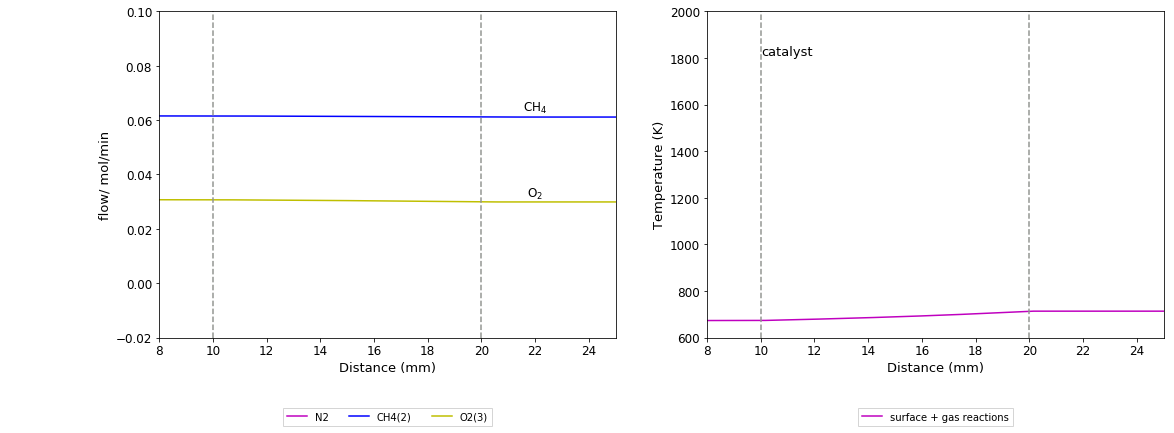

In [6]:
plotZoom(a)

In [147]:
# at different ratios
tot_flow = 0.208 # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
ratios = [.6,.7,.8,.9,1.,1.1,1.2,1.3,1.4,1.6,1.8,2.,2.2,2.4,2.6]

data = []
mole_ratios = []

for r in ratios:
    # get the moles in for a certain ratio
    fo2 = tot_flow/(2.*r+1+79/21)
    fch4 = 2*fo2*r
    far = 79*fo2/21
    
    moles_in = [fch4,fo2,far]
    mole_ratios.append([moles_in])
    
    try:
        a = monolithFull(gas,surf,temp_array,moles_in,False)
        plotflow(a)
        plotZoom(a)
        
        gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
        
        data.append([r,[gas_out,gas_names,dist_array,T_array]])
    except:
        print('Unable to run simulation at a C/O ratio of {:.0f}'.format(r))
        fixed_temp_errors.append(r)
        pass

[[0.06152112676056338, 0.03076056338028169, 0.11571830985915492]]


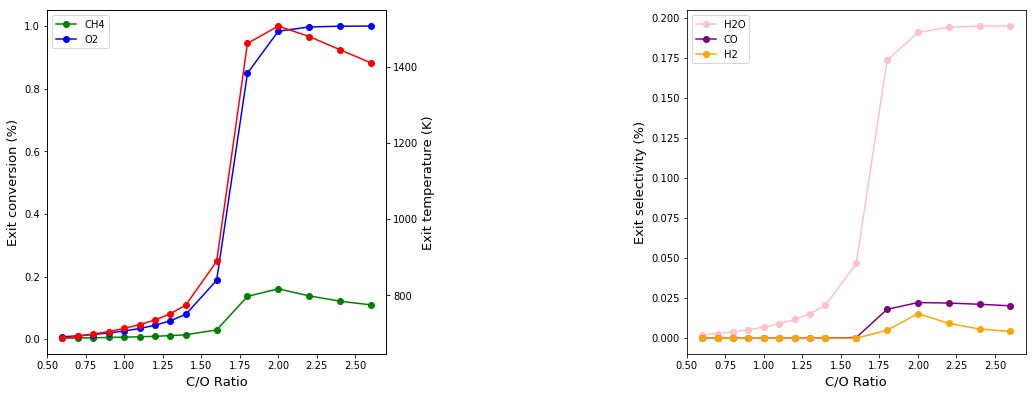

In [9]:
# finding exit conversions
end_temp = []
ch4_conv = []
o2_conv = []
co_sel = []
h2_sel = []
h2o_sel = []
# ratios = []
for r in data:
#     gas_out,gas_names,dist_array,T_array = r[1]
    for x in range(len(r[1][1])):
        if r[1][1][x]=='CH4(2)':
            ch4_in = r[1][0][0][x]
            ch4_out = r[1][0][-1][x]
            ch4_conv.append((ch4_in-ch4_out)/ch4_in)
        if r[1][1][x]=='O2(3)':
            o2_in = r[1][0][0][x]
            o2_out = r[1][0][-1][x]
            o2_conv.append((o2_in-o2_out)/o2_in)
    end_temp.append(r[1][3][-1])
    
    for x in range(len(r[1][1])):
        if r[1][1][x]=='Ar':
            ar = r[1][0][-1][x]
        if r[1][1][x]=='CO(7)':
            co_out = r[1][0][-1][x]
            co_sel.append(co_out/(1-ch4_out-o2_out-ar))
        if r[1][1][x]=='H2O(5)':
            h2o_out = r[1][0][-1][x]
            h2o_sel.append(h2o_out/(1-ch4_out-o2_out-ar))
        if r[1][1][x]=='H2(6)':
            h2_out = r[1][0][-1][x]
            h2_sel.append(h2_out/(1-ch4_out-o2_out-ar))
        
#     ratios.append(r[0])


fig, axs = plt.subplots(1,2)
# plot exit conversion and temp
axs[0].plot(ratios, ch4_conv,'bo-', label='CH4', color='green')
axs[0].plot(ratios, o2_conv, 'bo-',label='O2', color='blue')
ax2 = axs[0].twinx()
ax2.plot(ratios, end_temp, 'bo-',label='temp', color = 'red')

# plot exit selectivities
axs[1].plot(ratios, h2o_sel, 'bo-',label='H2O', color ='pink')
axs[1].plot(ratios, co_sel, 'bo-',label='CO', color ='purple')
axs[1].plot(ratios, h2_sel, 'bo-',label='H2', color ='orange')

axs[0].legend()
axs[1].legend()
axs[0].set_ylabel('Exit conversion (%)', fontsize=13);
ax2.set_ylabel('Exit temperature (K)', fontsize=13)
axs[0].set_xlabel('C/O Ratio', fontsize=13);
axs[1].set_ylabel('Exit selectivity (%)', fontsize=13)
axs[1].set_xlabel('C/O Ratio', fontsize=13)
plt.tight_layout()
fig.set_figheight(6)
fig.set_figwidth(16)
fig.savefig('fixed-temp-conversion&selectivity.png', bbox_inches='tight')

In [91]:
# end_temp
# print ratios
# ch4_conv
# o2_conv
# co_sel
# h2_sel 
# h2o_sel 
# print ch4_conv

# write this metal data to a csv file for later use in the lsr volcano plot

output = []
for x in range(len(ratios)):
    output.append([ratios[x],ch4_conv[x],o2_conv[x],co_sel[x],h2_sel[x],h2o_sel[x]])

k = (pd.DataFrame.from_dict(data=output, orient='columns'))
k.columns = ['C/O ratio','CH4 Conv','O2 Conv','CO Selec','H2 Selec','H2O Selec']
k.to_csv('fixed-temp-dict_conversions_selectivities.csv', header=True)

# def export(rxns_translated,ratio,sens_vals,sens_type=1):
#     answer = dict(zip(rxns_translated, sens_vals))
#     sorted_answer = sorted(answer.items(), key=operator.itemgetter(1), reverse=False)
#     # for x in sorted_answer:
#     #     print '%s %.4f'%(x)
    
#     # write to csv file
#     (pd.DataFrame.from_dict(data=sorted_answer, orient='columns')
#     .to_csv('dict_{}ratio_{}.csv'.format(ratio,sens_type), header=False))

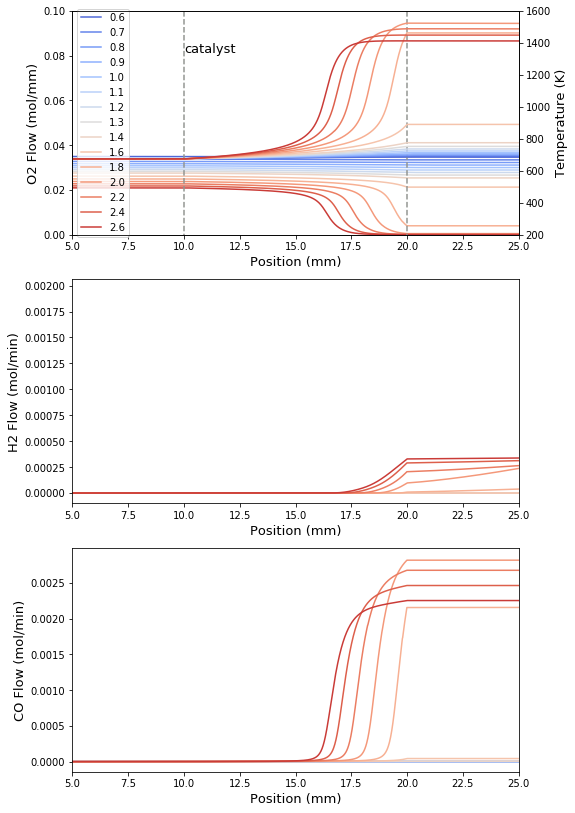

In [65]:
temps = []
o2 = []
co = []
h2 = []
ratios = []
for r in data:
    gas_out,gas_names,dist_array,T_array = r[1]
    for x in range(len(r[1][1])):
        if r[1][1][x]=='O2(3)':
            o2.append(r[1][0][:,x])
        if r[1][1][x]=='CO(7)':
            co.append(r[1][0][:,x])
        if r[1][1][x]=='H2(6)':
            h2.append(r[1][0][:,x])
    dist_array = r[1][2]
            
    temps.append(r[1][3])
    ratios.append(r[0])



fig, axs = plt.subplots(3,1)
sns.set_palette(sns.color_palette("coolwarm",15))
# sns.set_palette(sns.cubehelix_palette(15, start=.5, rot=-1))

# plot exit conversion and temp
for r in range(len(ratios)):
    axs[0].plot(dist_array,o2[r]*.208,label=ratios[r])
    axs[1].plot(dist_array,h2[r]*.208,label=ratios[r])
    axs[2].plot(dist_array,co[r]*.208,label=ratios[r])

ax2 = axs[0].twinx()

# sns.set_palette(sns.color_palette("coolwarm",15))
# sns.set_palette(sns.cubehelix_palette(15, start=.5, rot=-1))

for r in range(len(ratios)):
    ax2.plot(dist_array,temps[r])

axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-0.02,0.2], linestyle='--', color='xkcd:grey')
axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-0.02,0.2], linestyle='--', color='xkcd:grey')  
axs[0].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], 0.08), va =('bottom'), ha = ('left'))
# axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-0.02,.2], linestyle='--', color='xkcd:grey')
# axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-.02,0.2], linestyle='--', color='xkcd:grey')
# axs[1].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], .08), va =('bottom'), ha = ('left'))
# axs[2].plot([dist_array[on_catalyst], dist_array[on_catalyst]],[-.02,.2], linestyle='--', color='xkcd:grey')
# axs[2].plot([dist_array[off_catalyst], dist_array[off_catalyst]],[-.02,.2], linestyle='--', color='xkcd:grey')
# axs[2].annotate("catalyst", fontsize=13, xy=(dist_array[on_catalyst], .08), va =('bottom'), ha = ('left'))


axs[0].legend(loc='center left')
# axs[1].legend(loc='center left')
axs[0].set_ylabel('O2 Flow (mol/mm)', fontsize=13);
ax2.set_ylabel('Temperature (K)', fontsize=13)
# ax2.legend(loc='center right')
axs[0].set_xlabel('Position (mm)', fontsize=13);
axs[1].set_ylabel('H2 Flow (mol/min)', fontsize=13)
axs[2].set_ylabel('CO Flow (mol/min)', fontsize=13)
axs[1].set_xlabel('Position (mm)', fontsize=13)
axs[2].set_xlabel('Position (mm)', fontsize=13)
# axs[0].set_title('O2');axs[1].set_title('H2');axs[2].set_title('CO')
ax2.set_ylim(200,1600)
axs[0].set_ylim(0,.1)
axs[0].set_xlim(5,25);axs[1].set_xlim(5,25);axs[2].set_xlim(5,25)
# plt.tight_layout()
fig.set_figheight(14)
fig.set_figwidth(8)
fig.savefig('fixed-temp-flows.png', bbox_inches='tight')

In [166]:
##################
## SENSITIVITY
##################

def sensitivity(gas,surf,old_data,temp,dk):
    """
    Function to get sensitivity, but running additional simulations and comparing
    to the original simulation (data) to get a numberical value for sensitivity.
    
    old_data is an array with the original simulation output.
    
    Has multiple ways to calculate sensitivity.  You can use all at once, but was
    written so that the other ways could be commented out.
    """
    rxns = []
    sens1 = []
    sens2 = []
    sens3 = []
    
    gas_out_data,gas_names_data,dist_array_data,T_array_data = old_data
    
    reference = []
    for a in range(len(gas_names_data)):
        reference.append([gas_names_data[a],[gas_out_data[:,a]]])
        
    # getting the ratio
    for x in reference:
        if x[0]=='CH4(2)':
            ch4_in = x[1][0][0]
        if x[0]=='O2(3)':
            o2_in = x[1][0][0]
        if x[0]=='Ar':
            ar_in = x[1][0][0]
    ratio = ch4_in/(2*o2_in)
    moles_in = [ch4_in, o2_in, ar_in]
    
    #####################################
    ## Sensitivity definition 1:
    ##
    ## defining by amt of ch4 conversion
    ## from the beginning of the tube to
    ## the end of the tube
    ## 
    ## negative sensitivity is 'faster' depletion
    #####################################
    for x in reference:
        if x[0]=='CH4(2)':
            ch4_in = x[1][0][0]
            ch4_out = x[1][0][-1]
            reference_ch4_conv = (ch4_in-ch4_out)/(ch4_in)
    
    #####################################
    ## Sensitivity definition 2:
    ##
    ## defining by selectivity of h2 and co
    ## added together
    ##
    ## 
    #####################################
    for x in reference:
        if x[0]=='Ar':
            ar = x[1][0][-1]
        if x[0]=='O2(3)':
            o2_out = x[1][0][-1]
        if x[0]=='CO(7)':
            co_out = x[1][0][-1]
            reference_co_sel = co_out/(1-ch4_out-o2_out-ar)
        if x[0]=='H2(6)':
            h2_out = x[1][0][-1]
            reference_h2_sel = h2_out/(1-ch4_out-o2_out-ar)
    reference_prod_selectivity = reference_co_sel+reference_h2_sel
    
    #####################################
    ## Sensitivity definition 3:
    ##
    ## defining by h2 selectivity at the end
    ## of the tube
    ##
    ##
    #####################################
    reference_h2_sel
    
    #####################################
    ## Sensitivity definition 4:
    ##
    ## defining by co selectivity at the end
    ## of the tube
    ##
    ##
    #####################################
    reference_co_sel
    
    # run the simulations
    for rxn in range(surf.n_reactions):
        c = monolithFull(gas,surf,temp,moles_in,sens=[dk,rxn])
        gas_out, surf_out, gas_names, surf_names, dist_array, T_array = c
        
        # uncomment if sensitivity for surface only reactions are wanted
#         d = monolithNoGas(gas,surf,temp,sens=[dk,rxn])
#         gas2_out, surf2_out, gas2_names, surf2_names, dist2_array, T2_array = d
        
        new_amts = []
        for a in range(len(gas_names)):
            new_amts.append([gas_names[a],[gas_out[:,a]]])
        
        #####################################
        ## Sensitivity definition 1:
        #####################################
        for x in new_amts:
            if x[0]=='CH4(2)':
                new_ch4_out = x[1][0][-1]
                new_ch4_conv = (x[1][0][0]-new_ch4_out)/x[1][0][0]
        Sens1 = (reference_ch4_conv-new_ch4_conv)/(reference_ch4_conv*dk)
        sens1.append(Sens1)
#         print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens1)
        
        #####################################
        ## Sensitivity definition 2:
        #####################################
        for x in new_amts:
            if x[0]=='Ar':
                ar = x[1][0][-1]
            if x[0]=='O2(3)':
                new_o2_out = x[1][0][-1]
            if x[0]=='CO(7)':
                new_co_out = x[1][0][-1]
                new_co_sel = new_co_out/(1-new_o2_out-new_ch4_out-ar)
            if x[0]=='H2(6)':
                new_h2_out = x[1][0][-1]
                new_h2_sel = new_h2_out/(1-new_o2_out-new_ch4_out-ar)
        new_prod_selectivity = new_co_sel+new_h2_sel
        Sens2 = (reference_prod_selectivity-new_prod_selectivity)/(reference_prod_selectivity*dk)
        sens2.append(Sens2)
#         print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens2)

        #####################################
        ## Sensitivity definition 3:
        #####################################
        Sens3 = (reference_h2_sel-new_h2_sel)/(reference_h2_sel*dk)
        sens3.append(Sens3)
#         print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens3)
        
        #####################################
        ## Sensitivity definition 4:
        #####################################
        Sens4 = (reference_co_sel-new_co_sel)/(reference_co_sel*dk)
        sens4.append(Sens4)
#         print "%d %s %.3F"%(rxn,surf.reaction_equations()[rxn],Sens4)
        
        print "%d %s %.3F %.3F %.3F %.3F"%(rxn,surf.reaction_equations()[rxn],Sens1,Sens2,Sens3,Sens4)

        rxns.append(surf.reaction_equations()[rxn])
    return rxns,sens1,sens2,sens3,sens4

In [169]:
# Set the value of the perturbation
dk = 1.0e-2

# this takes the longest
sens_by_ratio = []
for r in range(len(data)):
    print data[r][0]
    try:
        reactions,sensitivity1,sensitivity2,sensitivity3,sensitivity4=sensitivity(gas,surf,data[r][1],data[r][0],dk)
        sens_by_ratio.append([data[r][0],sensitivity1,sensitivity2,sensitivity3,sensitivity4])
    except:
        print('Unable to run sensitivity simulation at a C/O ratio of {:.0f}'.format(data[r][0]))
        fixed_temp_errors.append(r)
        pass

800.0
0 CH4(2) + X(1) <=> CH4X(56) -0.000
0 CH4(2) + X(1) <=> CH4X(56) -0.000
0 CH4(2) + X(1) <=> CH4X(56) 0.000
1 O2(3) + 2 X(1) <=> 2 OX(20) 0.993
1 O2(3) + 2 X(1) <=> 2 OX(20) 1.007
1 O2(3) + 2 X(1) <=> 2 OX(20) 0.638
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) -0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.061
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.067
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.081
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.041
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.774
6 OH(17) + X(1) <=> HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.204
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
8 CH4(2) + 2 X(1) <=>

1 O2(3) + 2 X(1) <=> 2 OX(20) 1.074
1 O2(3) + 2 X(1) <=> 2 OX(20) 1.086
1 O2(3) + 2 X(1) <=> 2 OX(20) 1.278
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) -0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) -0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.547
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.452
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.458
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -3.636
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.029
6 OH(17) + X(1) <=> HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.895
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(

2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) 0.000
2 C2H6(8) + 2 X(1) <=> 2 CH3X(21) -0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.000
3 CH3(10) + X(1) <=> CH3X(21) 0.265
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.848
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -2.811
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -8.869
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.001
6 OH(17) + X(1) <=> HOX(22) -0.001
6 OH(17) + X(1) <=> HOX(22) -0.001
6 OH(17) + X(1) <=> HOX(22) -0.413
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX

3 CH3(10) + X(1) <=> CH3X(21) 0.004
3 CH3(10) + X(1) <=> CH3X(21) 0.001
3 CH3(10) + X(1) <=> CH3X(21) -0.004
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -3.354
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -1.986
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) 2.489
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.026
6 OH(17) + X(1) <=> HOX(22) -0.013
6 OH(17) + X(1) <=> HOX(22) 0.020
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.001
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.001
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) 0.001
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) 0.000
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.000
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.000


4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -0.298
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) -0.292
4 CH4(2) + OX(20) + X(1) <=> CH3X(21) + HOX(22) 3.478
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) 0.000
5 CH3OH(14) + 2 X(1) <=> CH3X(21) + HOX(22) -0.000
6 OH(17) + X(1) <=> HOX(22) -0.022
6 OH(17) + X(1) <=> HOX(22) -0.021
6 OH(17) + X(1) <=> HOX(22) 0.252
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) -0.000
7 H2(6) + 2 X(1) <=> 2 HX(19) 0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) -0.000
8 CH4(2) + 2 X(1) <=> CH3X(21) + HX(19) 0.005
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) -0.000
9 HX(19) + OX(20) <=> HOX(22) + X(1) 0.000
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.001
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) 0.001
10 H2O(5) + 2 X(1) <=> HOX(22) + HX(19) -0.007
11 H(12) + X(1) <=> HX(19) 0.000
11 H(12) + X(1) <=> HX(19) 0

In [219]:
species_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies('species_dictionary.txt')
keys = species_dict.keys()

# get the first listed smiles string for each molecule
smile = []
for s in species_dict:
    smile.append(species_dict[s].molecule[0])
    if len(species_dict[s].molecule) is not 1:
        print 'There are %d dupllicate smiles for %s:'%(len(species_dict[s].molecule),s)
        for a in range(len(species_dict[s].molecule)):
            print '%s'%(species_dict[s].molecule[a])
            
# translate the molecules from above into just smiles strings
smiles = []
for s in smile:
    smiles.append(s.toSMILES())
    
names = dict(zip(keys,smiles))

rxns_translated = []

# now replace each molecule with smiles
for x in reactions:
    for key, smile in names.iteritems():
        x = re.sub(re.escape(key), smile, x)
    rxns_translated.append(x)

def export(rxns_translated,ratio,sens_vals,sens_type=1):
    answer = dict(zip(rxns_translated, sens_vals))
    sorted_answer = sorted(answer.items(), key=operator.itemgetter(1), reverse=False)
    # for x in sorted_answer:
    #     print '%s %.4f'%(x)
    
    # write to csv file
    (pd.DataFrame.from_dict(data=sorted_answer, orient='columns')
    .to_csv('fixed-temp-dict_{}ratio_{}.csv'.format(ratio,sens_type), header=False))

In [221]:
# export everything
for x in sens_by_ratio:
    for s in range(len(x)-1):
        export(rxns_translated,x[0],x[s+1],s+1)

In [194]:
# if there are errors in generating models, print to a separate text file what they are
if len(fixed_temp_errors)==0:
    try:
        os.remove('fixed_temp_errors.txt')
    except:
        pass
if len(fixed_temp_errors) != 0:
    with open('fixed_temp_errors.txt','w') as f:
        f.write(str('Error at ratios: '))
        for x in range(len(fixed_temp_errors)):
            f.write(str(fixed_temp_errors[x]))
            if x != len(fixed_temp_errors)-1:
                f.write(str(', '))

# Batch reactor

plt.semilogy(surf.reverse_rates_of_progress,'.')

for i in surf.reverse_rates_of_progress.argsort()[:-5:-1]:
    print i, surf.reaction_equation(i)